# IE 582 Final Project
## Papatya Grubu: Tümay Kır, Egecan Esen

# Project Description

In this project,  we were given a train and test data with similar dimensions (2074 and 2073 observations). The training data has labels but the test data does not have any labels. The problem domain is unknown, and the feature names are not given. That makes the problem more challenging.

Our aim was to build a classification model using the training data to get the best results we can possibly obtain on the test data.

We used two performance measures to evaluate the performance of our models:

1) Balanced error rate

2) Area under the ROC curve

We used the mean of these two performance measures as our custom metric to optimize our models.

More detailed descriptive analysis of the data can be found in the output of our code. 

We used two libraries for our exploratory data analysis, pandas profile report and sweetviz.

Pandas profile report: This function provided us with an analysis which includes the distribution of each feature and how they relate to our target variable “y”.

Sweetviz: This function provided us with a similar report, however it also includes correlation matrix and some more analysis. It also has a compare function which let us compare the distribution of features in our training set and test set.

For our extended analysis, we tried to find which features had more importance. We did this by a function called SelectKBest and used chi squared test to see which features gave information about our target variable.

However, we noticed that these results were favoring the numeric features, so we scaled the data and repeated this procedure.

Another method we employed to see which features mattered to us more was “recursive feature elimination”. We used three different models (Logistic Regression, Random Forest Classifier and Gradient Boosting Classifier) and eliminated the least important features after we fit our models to get 30 features (we tried different number of features and 30 gave the best results).

The main problem with this project became apparent when we tried to fit the first models. The balanced error rate was low, which is due to the class imbalance in the training set. There are three times as many of one class than the other, so our predictions were skewed. To tackle this problem, we had to some research into related literature.


# Related Literature

The first method we found and employed to tackle the problem of imbalance was to use sample weights. Sklearn provides a method to give weights to each class when we are fitting the model. Using balanced weights increased the performance of the model in balanced error rate, however, it usually decreased our roc score. This was acceptable since the overall score improved.

Another way we discovered to fight against the imbalance of the train set is over sampling and under sampling. 

There were 3 methods we tried:

The first and most basic one was random under sampling. This method aims to create a new train set by dropping some of the excess class. However, the results obtained by this method was not satisfactory since we lost around 1000 observations when we fit the models on this new set

The second one is random over sampling. This method tries to increase the number of samples from the minority class by randomly creating new samples. This method also did not better results than using sample weights.

The last one we tried was SMOTE, more specifically SMOTENC. It means Synthetic Minority Oversampling Technique, NC stands for numeric and categorical. 

We tried all of these methods and we were careful not to use any data from our validation set when we were oversampling. This was achieved through using pipes.

A pipe is an object that has intermediate steps and functions similar to a model.  A SMOTE pipe, for example, first takes the train set and balances the data by adding new samples from the minority class. Then, this new train set is fed to the model and its performance is evaluated.


# Approach

After doing EDA and feature selection, we needed a way to evaluate the models. We created a function called get_score, which did cross validation on the given model using StratifiedKFold with 5 splits. The results for train and test set were reported in a dataframe format. 

Our later approach consisted of using several models and tune their hyperparameters. We tried the following classifiers:

1) K Neighbors Classifier

2) Support Vector Classifier

3) Logistic Regression

4) Decision Tree Classifier

5) Random Forest Classifier

6) Gradient Boosting Classifier (GradientBoostingClassifier, XGBoost, CatBoost)

We tried different number of features for each model and used the number of features that gave us the best performance.

After obtaining the best results from the above models, we used some ensemble techniques to get a better prediction. These ensemble techniques were:

Ada Boost Classifier: This method uses the same model multiple times to create different predictions and builds an ensemble on those created models.

Voting Classifier: A classifier which is build on several other classifiers and has a voting mechanism to choose the best one among the alternatives.

Stacking Classifier: This classifier, similar to voting classifier, has several base estimators and uses a final estimator (Logistic Regression) to bring together the results obtained from previous models.


Our exhaustive search and results are provided in the next sections of our report notebook.

However, we observed that the best results obtained from Logistic Regression and Random Forest Classifier were around .83 and the best results obtained from Gradient Boosting methods were around .84-.85. 

Higher scores that we submitted were obtained by increasing the decision boundary for the minority class. 


Conclusion and future work will be discussed at the end of the report.

# IMPORTS

In [135]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, recall_score, confusion_matrix, SCORERS
from sklearn.utils import class_weight
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from sklearn.feature_selection import chi2
import xgboost as xgb
import sweetviz as sv
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier, Pool
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# READING THE DATA

In [3]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Turning the y column into 1 and 0

le = LabelEncoder()
train["y"] = le.fit_transform(train["y"])

# Creating X and y

y = train["y"]
X = train.drop("y",1)

# EXPLORATORY DATA ANALYSIS

In [4]:
profile = ProfileReport(train, title='Train Profile Report', explorative = True)
profile.to_file(output_file='Train Profile Report.html')

In [333]:
report = ProfileReport(test, title='Test Profile Report', html={'style':{'full_width':True}})
report.to_file(output_file='Test Profile Report.html')

In [334]:
sv_report = sv.analyze(train,target_feat = "y")
sv_report.show_html('Train Sweet.html')


Report Train Sweet.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [335]:
test["y"] = 1
compare_report=sv.compare(train,test)
compare_report.show_html('Compare.html')


Report Compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [10]:
categorical_features = ["x2","x3","x4","x12","x13",
                        "x15","x16","x17", "x18","x19",
                        "x20", "x21", "x22", "x23", "x24",
                        "x25", "x26", "x28", "x29","x31",
                        "x33", "x34", "x35","x37","x38",
                        "x39", "x40","x41","x43","x44",
                        "x45","x46","x47","x48","x49",
                        "x50","x51","x52","x53","x54",
                        "x55","x56","x57","x58","x59","x60"]

categorical_features_index = [1,2,3,11,12,14,15,16,17,18,19,20,21,22,23,24,25,27,28,30,32,33,34,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59]

numeric_features = ["x1","x5","x6","x7","x8","x9","x10","x11","x14","x27","x30","x32","x36","x42"]

train_set_constant_features = ["x50", "x52"]
other_problematic_features = ["x37","x57"]

# PREPROCESSING STEPS

## Feature Selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. 
To select the best features, we implemented two different methods, which are "KBest" and "Recursive Feature Elimination". 

### Select K Best (chi2 score func)


This method selects features according to the k highest scores by using Chi-squared scoring. Here, k is the number of features you want to select.
It creates the object for SelectKBest and fit and transform the classification data.


In [8]:
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores = featureScores.sort_values(by="Score",ascending=False)
featureScores

,Specs,Score
41,x42,48979.255530
35,x36,15677.092073
29,x30,9039.850886
31,x32,6489.779740
13,x14,3428.356549
22,x23,196.084228
9,x10,176.527734
55,x56,168.354098
53,x54,137.349445
8,x9,107.209951


It can be seen that the numeric variables have very high importance scores. To get better results, let's first scale the data:

In [11]:
scaler = MinMaxScaler()
X_scaled = X[:]
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

We used MinMaxScaler to scale the data between the range (0,1) like our categorical variables.

In [12]:
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_scaled,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_scaled.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores = featureScores.sort_values(by="Score",ascending=False)
featureScores

,Specs,Score
22,x23,196.084228
55,x56,168.354098
53,x54,137.349445
57,x58,90.717947
47,x48,73.908584
37,x38,53.254437
23,x24,52.603837
16,x17,49.678027
41,x42,49.028284
15,x16,41.541089


There is a drastic change in the importance of some features. This is interesting. The scaled feature importance results are preferred.

Let's drop n least important features from our data:

In [13]:
n = 20 # The number of features to drop
features_to_drop = list(featureScores["Specs"].iloc[-n:].values)
X_selected20 = X.drop(features_to_drop,1)

In [14]:
n1 = 30 # The number of features to drop
features_to_drop1 = list(featureScores["Specs"].iloc[-n1:].values)
X_selected30 = X.drop(features_to_drop1,1)

In [15]:
n2 = 35 # The number of features to drop
features_to_drop2 = list(featureScores["Specs"].iloc[-n2:].values)
X_selected35 = X.drop(features_to_drop2,1)

### Recursive Feature Elimination

The Recursive Feature Elimination (RFE) works by recursively removing attributes and building a model on those attributes that remain.

It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

The example below uses RFE with the random forest algorithm to select the top 30 features. The choice of algorithm does not matter too much as long as it is skillful and consistent.

In [17]:
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=30, step=1)
selector = selector.fit(X, y)
features_to_keep = list(X.columns[selector.support_])
X_selected_rf = X[features_to_keep]

And then, RFE with logistic regression and gradient boosting are applied, respectively.

In [18]:
estimator = LogisticRegression(class_weight='balanced')
selector = RFE(estimator, n_features_to_select=30, step=1)
selector = selector.fit(X, y)
features_to_keep1 = list(X.columns[selector.support_])
X_selected_lr = X[features_to_keep1]

In [19]:
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=30, step=1)
selector = selector.fit(X, y)
features_to_keep2 = list(X.columns[selector.support_])
X_selected_gb = X[features_to_keep2]

# EVALUATION FUNCTIONS

We may want to fit the models with balanced sample weight as this problem has a class imbalance problem (3:1).

That's why an option to use sample weight when we fit the models is given in our get_score function.

It returns the scores acquired from 5 fold stratified cross validation as a dataframe.

In [22]:
def custom_score(y_true, y_pred):
    
    return (balanced_accuracy_score(y_true, y_pred.round()) + roc_auc_score(y_true,y_pred))/2

# To use this function as a scorer, use make_scorer(custom_score,needs_proba=True)

In [23]:
def get_score(model, X, y, cv = StratifiedKFold(n_splits=5, shuffle=True), sample_weight = False):
    
    if sample_weight:
        scores = cross_validate(model, X, y, cv=cv,
                        scoring = ["roc_auc","balanced_accuracy"],
                        return_train_score=True,
                        fit_params={'sample_weight': class_weight.compute_sample_weight(class_weight='balanced', y=y)})
        
        scores = pd.DataFrame(scores)

        scores["test ort"] = (scores["test_roc_auc"] + scores["test_balanced_accuracy"])/2
        scores["train ort"] = (scores["train_roc_auc"] + scores["train_balanced_accuracy"])/2

        scores.loc['Mean'] = scores.mean()
        scores.loc['SD'] = scores.std()
        
        return scores
    
    else:
        scores = cross_validate(model, X, y, cv=cv,
                            scoring = ["roc_auc","balanced_accuracy"],
                            return_train_score=True)

        scores = pd.DataFrame(scores)

        scores["test ort"] = (scores["test_roc_auc"] + scores["test_balanced_accuracy"])/2
        scores["train ort"] = (scores["train_roc_auc"] + scores["train_balanced_accuracy"])/2

        scores.loc['Mean'] = scores.mean()
        scores.loc['SD'] = scores.std()
    
    return scores

Let's define our custom scoring function, which is the mean of balanced accuracy score and area under the curve score.

I think we are ready to try some models.

# MODELS

### Decision Tree 

In [46]:
get_score(DecisionTreeClassifier(), X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.018894,0.005223,0.731927,1.0,0.731927,1.0,0.731927,1.0
1,0.017573,0.005668,0.680151,1.0,0.680151,1.0,0.680151,1.0
2,0.017192,0.005721,0.697723,1.0,0.697723,1.0,0.697723,1.0
3,0.017677,0.005091,0.725318,1.0,0.725318,1.0,0.725318,1.0
4,0.020713,0.006197,0.687613,1.0,0.687613,1.0,0.687613,1.0
Mean,0.018410,0.005580,0.704546,1.0,0.704546,1.0,0.704546,1.0
SD,0.001285,0.000394,0.020541,0.0,0.020541,0.0,0.020541,0.0


In [47]:
get_score(DecisionTreeClassifier(), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.007621,0.005337,0.722483,0.999332,0.719147,0.971775,0.720815,0.985553
1,0.005612,0.004801,0.689047,0.999186,0.679932,0.965602,0.684489,0.982394
2,0.005640,0.005423,0.749859,0.999131,0.736610,0.967690,0.743234,0.983410
3,0.007492,0.010322,0.763390,0.999118,0.745035,0.968089,0.754213,0.983604
4,0.007288,0.005720,0.762867,0.999306,0.752776,0.971015,0.757821,0.985161
Mean,0.006731,0.006321,0.737529,0.999214,0.726700,0.968834,0.732115,0.984024
SD,0.000908,0.002023,0.028424,0.000089,0.025918,0.002268,0.027088,0.001170


In [48]:
get_score(DecisionTreeClassifier(), X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.006632,0.004899,0.748371,0.999163,0.735889,0.984763,0.742130,0.991963
1,0.006269,0.004488,0.721638,0.999054,0.711990,0.982736,0.716814,0.990895
2,0.006117,0.004932,0.776342,0.999204,0.761668,0.984395,0.769005,0.991799
3,0.005865,0.004780,0.695765,0.999344,0.692711,0.987160,0.694238,0.993252
4,0.006765,0.004697,0.714058,0.999327,0.706134,0.986794,0.710096,0.993060
Mean,0.006330,0.004759,0.731235,0.999218,0.721678,0.985169,0.726457,0.992194
SD,0.000330,0.000160,0.028191,0.000107,0.024395,0.001630,0.026286,0.000868


Sample weight gives worse results. This is interesting.

Let's try to visualize the model:

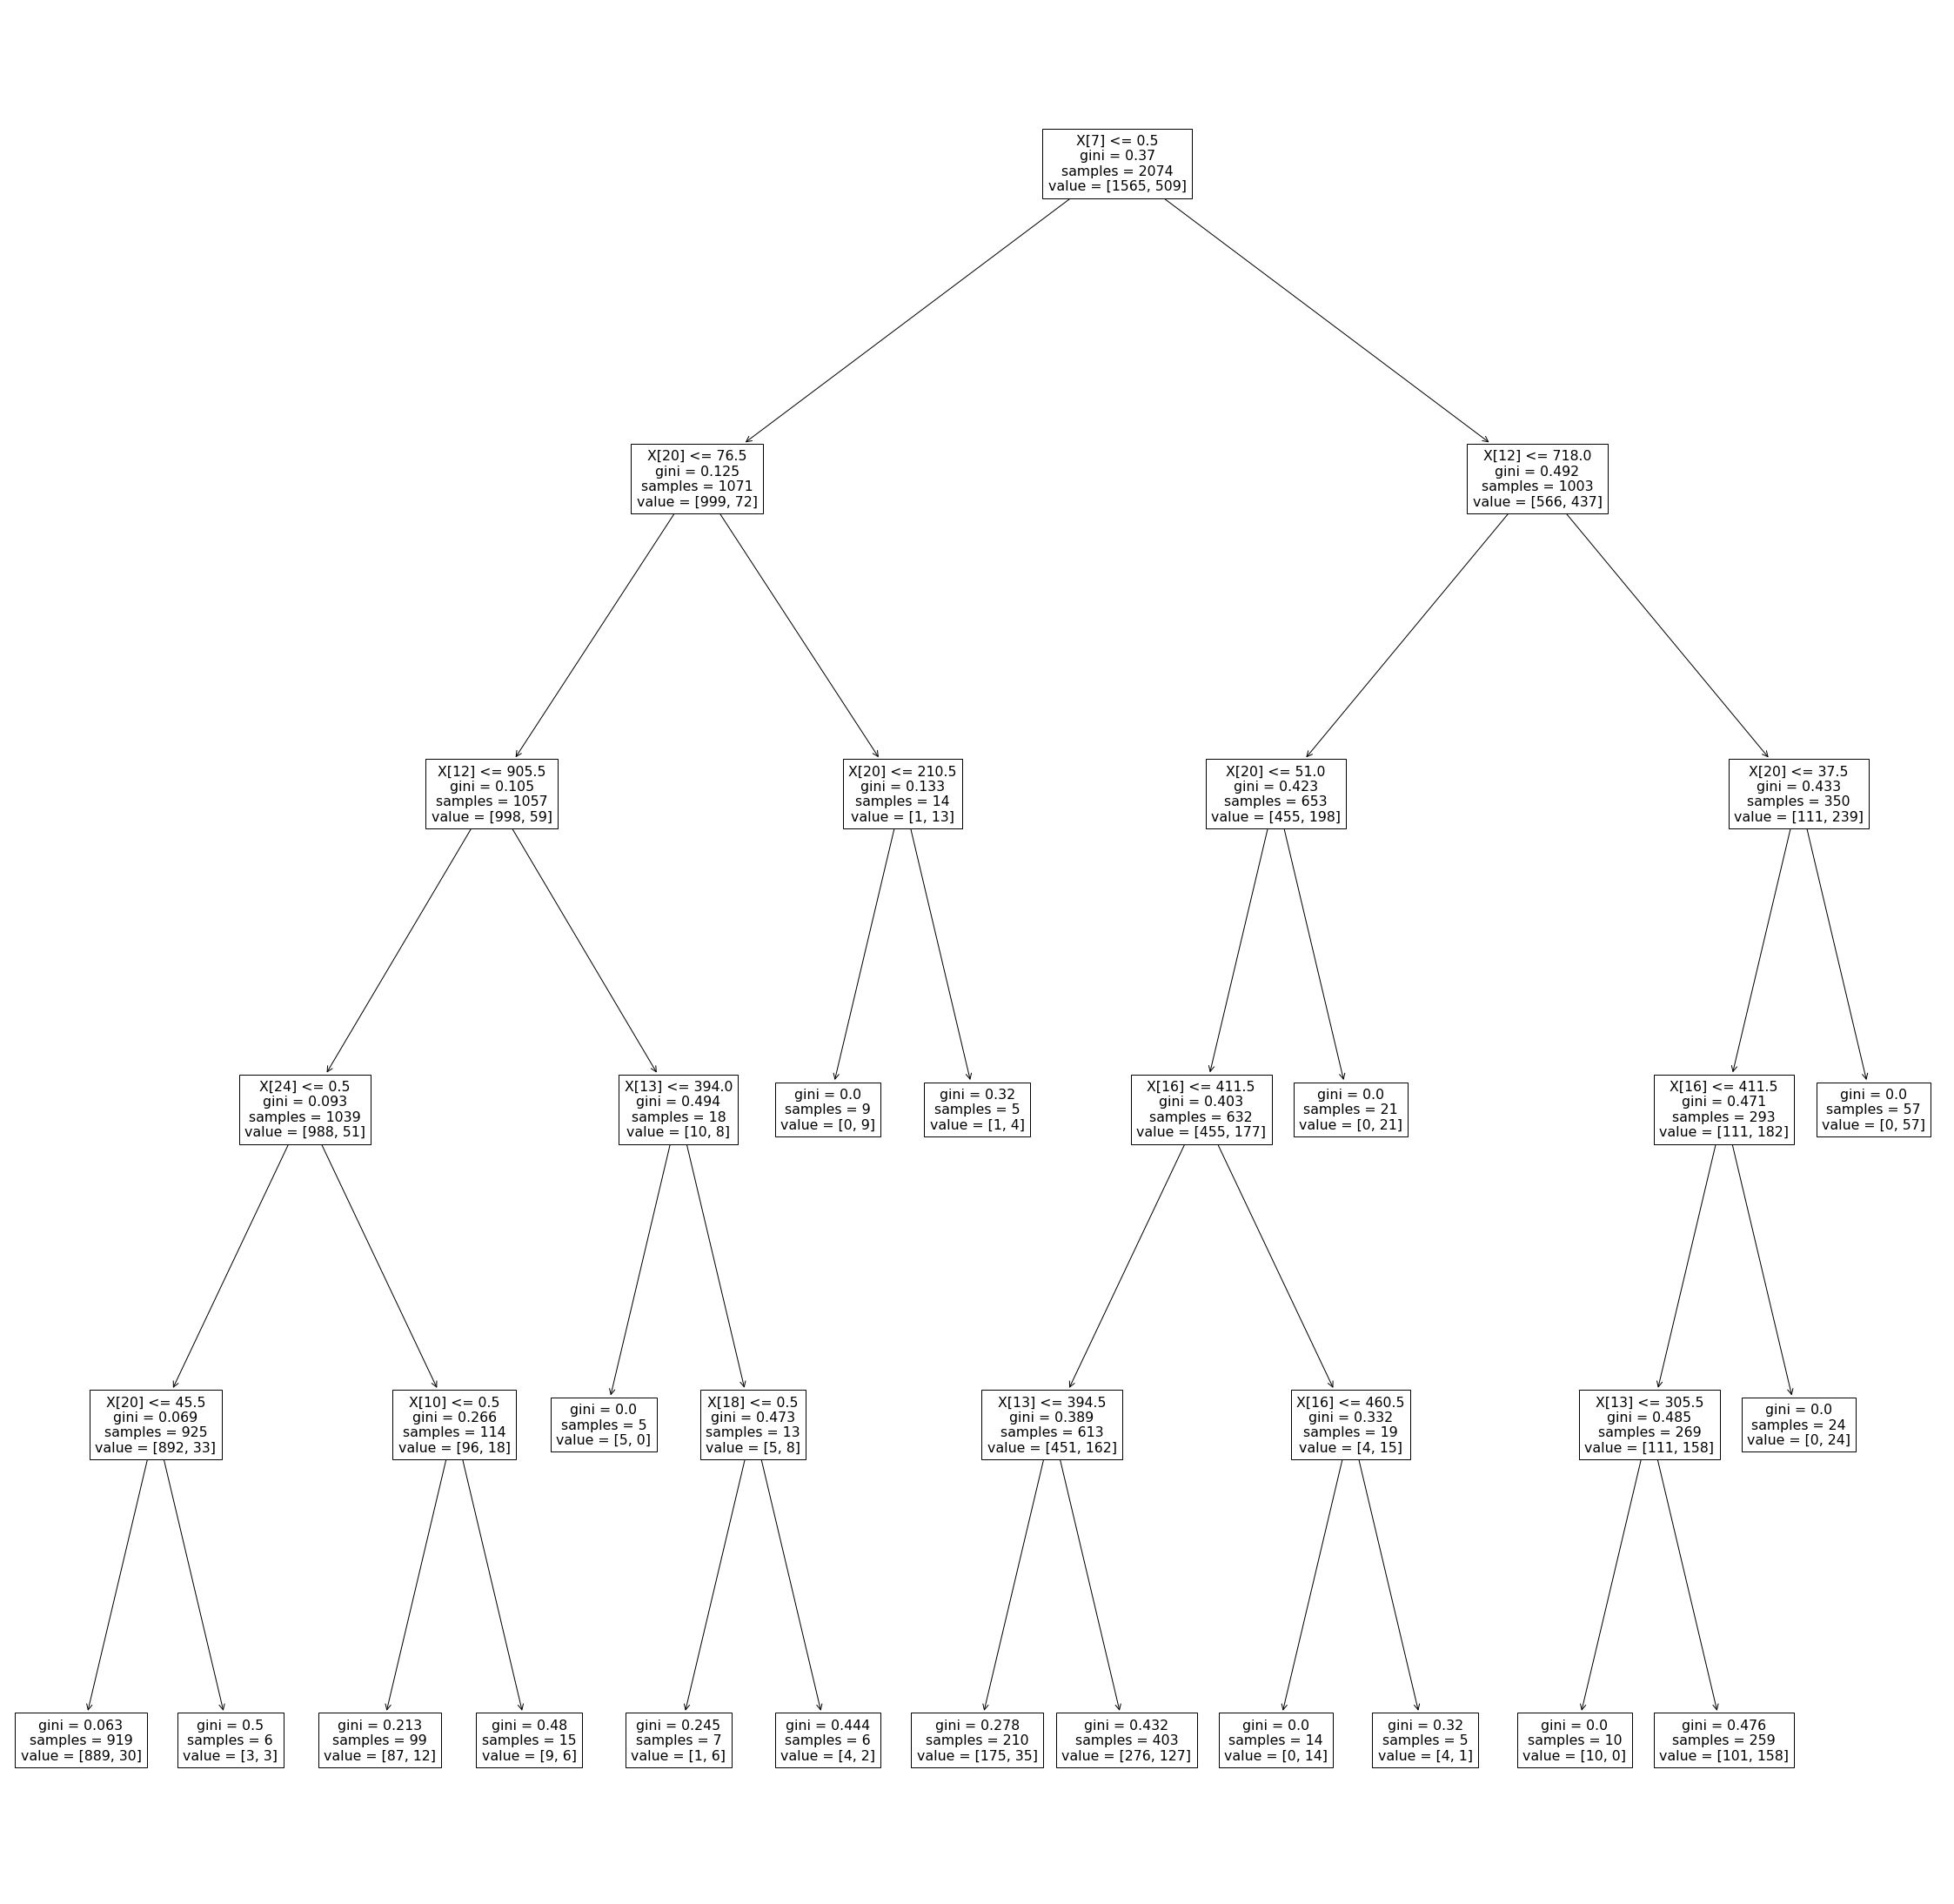

In [50]:
dt = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=5, max_depth=5)
dt.fit(X_selected30, y)
plt.figure(figsize=(40,40))
plot_tree(dt)
plt.savefig("dt.png")

We can see which variables are more important in the tree learning method from the above figure.

The depth is set to 5 for ease of use.

### Logistic Regression

Logistic regression is a powerful machine learning algorithm that utilizes a sigmoid function and works best on binary classification problems. Thus, we use used it with "get_score" function to see the accuracy and ROC values. Also, checking overfitting cases is possible with this table below.

We applied logistic regression to different data sets according to their number of features. It can be observed that when 30 or 25 features are dropped, the best results can be obtained in "test ort" column.

Moreover, we tried the datasets whose features are reduced by Recursive Feature Elimination according to RF, gradient boosting and logistic regression models. Obviously, the best results are obtained with X_selected_lr.

Then, since weights are important, we set the parameter "sample_weight" as True. We observed that the results are improved.

Another parameter for LogisticRegression function is "class_weight". Balanced class weight also improves the accuracy but not much "sample_weight" does.

In [24]:
get_score(LogisticRegression(), X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.030224,0.006584,0.843764,0.856181,0.692053,0.711017,0.767909,0.783599
1,0.031131,0.006198,0.858141,0.849463,0.709735,0.690562,0.783938,0.770013
2,0.029942,0.005851,0.851876,0.845841,0.691944,0.693388,0.771910,0.769614
3,0.031681,0.004635,0.858579,0.851226,0.716673,0.702048,0.787626,0.776637
4,0.035140,0.008493,0.827128,0.864419,0.679958,0.717816,0.753543,0.791118
Mean,0.031624,0.006352,0.847898,0.853426,0.698073,0.702966,0.772985,0.778196
SD,0.001865,0.001254,0.011690,0.006427,0.013296,0.010313,0.012159,0.008236


In [25]:
get_score(LogisticRegression(), X_selected20, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.033018,0.006363,0.836215,0.882849,0.683847,0.750359,0.760031,0.816604
1,0.034806,0.005478,0.839206,0.886664,0.718270,0.748089,0.778738,0.817376
2,0.030229,0.005865,0.842135,0.870259,0.692053,0.712063,0.767094,0.791161
3,0.031661,0.005228,0.893003,0.870968,0.786788,0.727387,0.839895,0.799177
4,0.027805,0.005369,0.900009,0.868454,0.755022,0.734891,0.827516,0.801672
Mean,0.031504,0.005661,0.862114,0.875839,0.727196,0.734558,0.794655,0.805198
SD,0.002389,0.000410,0.028231,0.007426,0.038780,0.014074,0.032675,0.010238


In [26]:
get_score(LogisticRegression(), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.033128,0.005270,0.874507,0.868649,0.716454,0.734358,0.795480,0.801504
1,0.028316,0.005106,0.874992,0.874559,0.736281,0.727816,0.805636,0.801188
2,0.029760,0.005143,0.873974,0.880589,0.739476,0.725238,0.806725,0.802913
3,0.027240,0.005254,0.854993,0.874812,0.731379,0.726158,0.793186,0.800485
4,0.026927,0.004901,0.860659,0.871794,0.717173,0.734546,0.788916,0.803170
Mean,0.029074,0.005135,0.867825,0.874081,0.728152,0.729623,0.797989,0.801852
SD,0.002256,0.000133,0.008365,0.003946,0.009614,0.004029,0.007021,0.001029


In [27]:
get_score(LogisticRegression(), X_selected35, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.028757,0.004713,0.893754,0.870193,0.727855,0.725298,0.810805,0.797746
1,0.030721,0.004918,0.870920,0.876739,0.724989,0.734758,0.797955,0.805748
2,0.028658,0.005075,0.857295,0.880394,0.718270,0.735678,0.787783,0.808036
3,0.029651,0.005096,0.860725,0.877077,0.726477,0.740774,0.793601,0.808926
4,0.026647,0.004487,0.866289,0.878625,0.734413,0.732522,0.800351,0.805573
Mean,0.028887,0.004858,0.869797,0.876605,0.726401,0.733806,0.798099,0.805206
SD,0.001344,0.000231,0.012854,0.003458,0.005185,0.005040,0.007658,0.003948


In [28]:
get_score(LogisticRegression(), X_selected_rf, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.029933,0.004786,0.830984,0.840927,0.685225,0.672534,0.758105,0.756730
1,0.027793,0.005606,0.851124,0.846824,0.690237,0.692099,0.770681,0.769461
2,0.030422,0.004642,0.872298,0.846392,0.709954,0.691760,0.791126,0.769076
3,0.026259,0.005159,0.830984,0.835075,0.690456,0.679814,0.760720,0.757444
4,0.026417,0.004372,0.800747,0.847546,0.659839,0.697699,0.730293,0.772623
Mean,0.028165,0.004913,0.837228,0.843353,0.687142,0.686781,0.762185,0.765067
SD,0.001735,0.000430,0.023799,0.004760,0.016063,0.009207,0.019727,0.006634


In [29]:
get_score(LogisticRegression(), X_selected_lr, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.015881,0.005093,0.863090,0.847978,0.737878,0.701280,0.800484,0.774629
1,0.016675,0.005485,0.808526,0.861321,0.657849,0.708160,0.733188,0.784740
2,0.012214,0.005710,0.836685,0.852845,0.657740,0.705764,0.747212,0.779304
3,0.017949,0.004778,0.868007,0.847264,0.724770,0.707822,0.796389,0.777543
4,0.013050,0.005825,0.826464,0.857687,0.703113,0.714304,0.764788,0.785995
Mean,0.015154,0.005378,0.840554,0.853419,0.696270,0.707466,0.768412,0.780442
SD,0.002178,0.000390,0.022364,0.005449,0.033320,0.004208,0.026513,0.004308


In [30]:
get_score(LogisticRegression(), X_selected_gb, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.028468,0.004721,0.835714,0.832861,0.713368,0.672412,0.774541,0.752637
1,0.030954,0.006294,0.857326,0.842320,0.706759,0.695754,0.782043,0.769037
2,0.028397,0.004761,0.843137,0.834305,0.636315,0.698610,0.739726,0.766458
3,0.028245,0.005289,0.830232,0.849161,0.662642,0.700051,0.746437,0.774606
4,0.026605,0.006394,0.823142,0.841199,0.682678,0.687124,0.752910,0.764162
Mean,0.028534,0.005492,0.837910,0.839969,0.680353,0.690790,0.759131,0.765380
SD,0.001392,0.000725,0.011715,0.005901,0.028446,0.010225,0.016363,0.007260


In [31]:
get_score(LogisticRegression(), X_selected20, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.032409,0.006343,0.902368,0.875686,0.803029,0.781695,0.852698,0.828690
1,0.031111,0.004502,0.839974,0.887392,0.743704,0.790850,0.791839,0.839121
2,0.028018,0.006029,0.863278,0.881519,0.790578,0.786118,0.826928,0.833819
3,0.032011,0.004212,0.891217,0.878000,0.797078,0.780926,0.844147,0.829463
4,0.030345,0.005630,0.855819,0.881490,0.749723,0.784341,0.802771,0.832915
Mean,0.030779,0.005343,0.870531,0.880817,0.776822,0.784786,0.823677,0.832802
SD,0.001555,0.000841,0.022997,0.003961,0.024970,0.003555,0.023335,0.003716


In [32]:
get_score(LogisticRegression(), X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.030763,0.004978,0.892235,0.871191,0.795590,0.780432,0.843912,0.825811
1,0.031957,0.004731,0.890951,0.870653,0.810515,0.779972,0.850733,0.825312
2,0.028847,0.005282,0.835291,0.884252,0.756593,0.794132,0.795942,0.839192
3,0.040363,0.004661,0.851406,0.880658,0.759679,0.797296,0.805543,0.838977
4,0.029781,0.005488,0.871698,0.877757,0.788204,0.785868,0.829951,0.831813
Mean,0.032342,0.005028,0.868316,0.876902,0.782116,0.787540,0.825216,0.832221
SD,0.004141,0.000317,0.022237,0.005301,0.020880,0.007060,0.021294,0.006053


In [33]:
get_score(LogisticRegression(), X_selected35, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.029577,0.004740,0.857608,0.882502,0.766507,0.793885,0.812058,0.838194
1,0.027414,0.004989,0.861837,0.878743,0.782701,0.789587,0.822269,0.834165
2,0.026332,0.004678,0.872314,0.875711,0.782043,0.783718,0.827178,0.829715
3,0.028165,0.004527,0.874742,0.885559,0.781103,0.799970,0.827922,0.842765
4,0.025532,0.005368,0.888622,0.875729,0.794594,0.792230,0.841608,0.833980
Mean,0.027404,0.004860,0.871024,0.879649,0.781390,0.791878,0.826207,0.835764
SD,0.001411,0.000294,0.010859,0.003867,0.008923,0.005319,0.009558,0.004410


In [34]:
get_score(LogisticRegression(), X_selected_rf, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.031065,0.005584,0.877498,0.853014,0.779067,0.755341,0.828283,0.804177
1,0.030072,0.006079,0.849527,0.861179,0.748387,0.770269,0.798957,0.815724
2,0.031824,0.006380,0.848055,0.860591,0.764690,0.763880,0.806373,0.812235
3,0.027903,0.004832,0.839191,0.861476,0.733462,0.772357,0.786326,0.816917
4,0.030072,0.007682,0.838990,0.859405,0.747003,0.759307,0.792997,0.809356
Mean,0.030187,0.006111,0.850652,0.859133,0.754522,0.764231,0.802587,0.811682
SD,0.001319,0.000944,0.014114,0.003141,0.015771,0.006417,0.014451,0.004600


In [35]:
get_score(LogisticRegression(), X_selected_lr, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.019270,0.006284,0.829763,0.856418,0.745302,0.778682,0.787532,0.817550
1,0.015251,0.005067,0.842667,0.852780,0.756374,0.773981,0.799521,0.813381
2,0.014718,0.004871,0.875994,0.844850,0.774275,0.767409,0.825135,0.806129
3,0.015467,0.005208,0.844703,0.852910,0.763312,0.761114,0.804008,0.807012
4,0.017536,0.004489,0.818524,0.859123,0.743001,0.768504,0.780763,0.813814
Mean,0.016448,0.005184,0.842330,0.853216,0.756453,0.769938,0.799392,0.811577
SD,0.001705,0.000601,0.019307,0.004805,0.011576,0.005985,0.015308,0.004346


In [36]:
get_score(LogisticRegression(), X_selected_gb, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.033438,0.004106,0.850561,0.856697,0.737095,0.771129,0.793828,0.813913
1,0.039802,0.004408,0.859080,0.859949,0.777141,0.759026,0.818111,0.809488
2,0.031816,0.004229,0.877968,0.855580,0.800053,0.755341,0.839011,0.805461
3,0.027848,0.005049,0.842072,0.860565,0.750313,0.779728,0.796193,0.820147
4,0.027809,0.004402,0.843229,0.862753,0.748284,0.765986,0.795756,0.814370
Mean,0.032143,0.004439,0.854582,0.859109,0.762577,0.766242,0.808580,0.812676
SD,0.004420,0.000325,0.013181,0.002622,0.022894,0.008680,0.017620,0.004948


In [37]:
get_score(LogisticRegression(class_weight='balanced'), X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.035666,0.005261,0.848024,0.865534,0.754886,0.777211,0.801455,0.821372
1,0.033110,0.004389,0.878876,0.856122,0.790359,0.765199,0.834618,0.810661
2,0.031783,0.005169,0.837812,0.864443,0.743266,0.771928,0.790539,0.818185
3,0.030967,0.005460,0.850592,0.863630,0.756593,0.777271,0.803593,0.820451
4,0.038499,0.006274,0.869231,0.858104,0.781182,0.765352,0.825206,0.811728
Mean,0.034005,0.005311,0.856907,0.861567,0.765257,0.771392,0.811082,0.816479
SD,0.002754,0.000604,0.014953,0.003739,0.017606,0.005358,0.016274,0.004451


In [38]:
get_score(LogisticRegression(class_weight='balanced'), X_selected20, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.035784,0.004343,0.849558,0.881726,0.756155,0.791279,0.802857,0.836503
1,0.031205,0.006671,0.859895,0.884148,0.793773,0.788237,0.826834,0.836192
2,0.030933,0.005686,0.854147,0.883531,0.759679,0.785658,0.806913,0.834594
3,0.031047,0.005919,0.871797,0.879367,0.767447,0.780679,0.819622,0.830023
4,0.029126,0.008229,0.894331,0.876185,0.812640,0.780637,0.853486,0.828411
Mean,0.031619,0.006170,0.865946,0.880992,0.777939,0.785298,0.821942,0.833145
SD,0.002215,0.001275,0.016027,0.002922,0.021785,0.004186,0.017969,0.003311


In [39]:
get_score(LogisticRegression(class_weight='balanced'), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.032726,0.004163,0.885423,0.876346,0.788981,0.784426,0.837202,0.830386
1,0.032060,0.005053,0.843216,0.882161,0.740180,0.799845,0.791698,0.841003
2,0.031098,0.005934,0.884733,0.875037,0.806553,0.791275,0.845643,0.833156
3,0.030290,0.004214,0.863669,0.883909,0.745521,0.793885,0.804595,0.838897
4,0.030285,0.005977,0.874213,0.876683,0.772546,0.785152,0.823380,0.830917
Mean,0.031292,0.005068,0.870251,0.878827,0.770756,0.790916,0.820503,0.834872
SD,0.000970,0.000791,0.015683,0.003523,0.025252,0.005727,0.020010,0.004301


In [40]:
get_score(LogisticRegression(class_weight='balanced'), X_selected35, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.032636,0.005105,0.885219,0.882142,0.816137,0.788024,0.850678,0.835083
1,0.028671,0.005938,0.916494,0.869337,0.813491,0.780862,0.864992,0.825099
2,0.027760,0.004217,0.850357,0.881828,0.745521,0.789739,0.797939,0.835784
3,0.027665,0.004550,0.851406,0.883381,0.743485,0.805835,0.797446,0.844608
4,0.029506,0.005911,0.853968,0.881603,0.774792,0.792657,0.814380,0.837130
Mean,0.029248,0.005144,0.871489,0.879658,0.778685,0.791423,0.825087,0.835541
SD,0.001822,0.000697,0.025965,0.005197,0.031522,0.008187,0.027796,0.006229


In [41]:
get_score(LogisticRegression(class_weight='balanced'), X_selected_rf, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.032216,0.005657,0.830734,0.860962,0.724817,0.779455,0.777775,0.820208
1,0.032004,0.005405,0.892220,0.846121,0.797187,0.759026,0.844703,0.802574
2,0.029475,0.005246,0.858047,0.857400,0.752850,0.763419,0.805449,0.810409
3,0.033700,0.004220,0.860678,0.858587,0.769921,0.761331,0.815299,0.809959
4,0.031645,0.009052,0.808402,0.869636,0.727833,0.775473,0.768118,0.822555
Mean,0.031808,0.005916,0.850016,0.858541,0.754522,0.767741,0.802269,0.813141
SD,0.001360,0.001643,0.028506,0.007543,0.027037,0.008157,0.027375,0.007319


In [42]:
get_score(LogisticRegression(class_weight='balanced'), X_selected35, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.033134,0.004191,0.870685,0.876168,0.756640,0.757040,0.813663,0.816604
1,0.030515,0.004643,0.863121,0.878106,0.729813,0.751879,0.796467,0.814992
2,0.038478,0.006740,0.864390,0.881078,0.748653,0.756550,0.806521,0.818814
3,0.026485,0.005447,0.868383,0.878182,0.742044,0.752647,0.805214,0.815415
4,0.037818,0.005049,0.882912,0.866662,0.754326,0.746339,0.818619,0.806501
Mean,0.033286,0.005214,0.869898,0.876039,0.746295,0.752891,0.808097,0.814465
SD,0.004504,0.000870,0.007051,0.004943,0.009662,0.003863,0.007586,0.004198


It is a good idea to use balanced class weights, however, not together with sample weights. 

I will use class_weight='balanced' to more easily search the grid of hyperparameters.

While executing grid search, we first tried wider ranges for parameters, then, we make search in a smaller range by taking the results into account.

In [43]:
log_grid_search = {'penalty': [None, "l1", "l2"],
                    'C': list(np.logspace(-4,3,8)),
                    'class_weight': ["balanced"],
                   'max_iter': [2500],
                   'dual': [True, False],
                   'tol': [1e-6,1e-5,1e-4,1e-3]
                    }

log_model_grid = GridSearchCV(estimator=LogisticRegression(),
                                     param_grid=log_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

log_model_grid.fit(X_selected30, y)

print(log_model_grid.best_params_)

get_score(log_model_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   18.8s finished


{'C': 100.0, 'class_weight': 'balanced', 'dual': False, 'max_iter': 2500, 'penalty': 'l2', 'tol': 1e-06}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.627931,0.005187,0.876261,0.890529,0.795151,0.803165,0.835706,0.846847
1,0.243330,0.004784,0.886409,0.886939,0.813052,0.796931,0.849731,0.841935
2,0.203576,0.004211,0.886268,0.886685,0.810076,0.796163,0.848172,0.841424
3,0.222917,0.004834,0.830875,0.899350,0.738473,0.810384,0.784674,0.854867
4,0.284859,0.005295,0.899820,0.883206,0.807057,0.797657,0.853438,0.840432
Mean,0.316523,0.004862,0.875926,0.889342,0.792762,0.800860,0.834344,0.845101
SD,0.158021,0.000380,0.023738,0.005515,0.027817,0.005362,0.025540,0.005362


We can also increase the number of iterations for a better performance.

In [45]:
get_score(LogisticRegression(C=100, class_weight='balanced', penalty='l2', tol=1e-6, max_iter=20000), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.420371,0.004691,0.887897,0.887068,0.809638,0.800617,0.848767,0.843842
1,0.185595,0.004429,0.904028,0.883501,0.808917,0.788974,0.856473,0.836238
2,0.419653,0.007057,0.862025,0.892798,0.770751,0.803382,0.816388,0.848090
3,0.441126,0.004572,0.892658,0.886090,0.808479,0.789313,0.850569,0.837701
4,0.263929,0.006083,0.853130,0.895236,0.754990,0.809665,0.804060,0.852451
Mean,0.346135,0.005366,0.879948,0.888939,0.790555,0.798390,0.835251,0.843664
SD,0.102440,0.001033,0.019210,0.004376,0.023150,0.008100,0.020959,0.006124


Slightly better results, however, there is still room for improvement and slight overfitting.

In [81]:
BEST_LR = LogisticRegression(C=100, class_weight='balanced', penalty='l2', tol=1e-6, max_iter=20000)

### Random Forest

Random Forest is a method that ensembles basic decision tree models.

This time, we repeated the same steps for Random Forest method.

In [51]:
get_score(RandomForestClassifier(), X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.290806,0.030200,0.907348,1.0,0.706211,1.0,0.806780,1.0
1,0.259309,0.034178,0.863716,1.0,0.701857,1.0,0.782787,1.0
2,0.278460,0.029813,0.874804,1.0,0.773570,1.0,0.824187,1.0
3,0.291237,0.037714,0.853348,1.0,0.691944,1.0,0.772646,1.0
4,0.302550,0.028471,0.880302,1.0,0.728514,1.0,0.804408,1.0
Mean,0.284472,0.032075,0.875904,1.0,0.720419,1.0,0.798162,1.0
SD,0.014711,0.003401,0.018257,0.0,0.029147,0.0,0.018320,0.0


In [52]:
get_score(RandomForestClassifier(), X_selected20, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.230493,0.037718,0.871468,1.000000,0.754182,1.000000,0.812825,1.000000
1,0.195313,0.031955,0.872173,0.999999,0.721246,0.998771,0.796710,0.999385
2,0.221226,0.028417,0.866347,0.999996,0.747463,0.998372,0.806905,0.999184
3,0.199905,0.029404,0.892470,0.999992,0.752474,0.998372,0.822472,0.999182
4,0.197010,0.030176,0.883655,0.999999,0.778177,0.999601,0.830916,0.999800
Mean,0.208789,0.031534,0.877223,0.999997,0.750708,0.999023,0.813966,0.999510
SD,0.014318,0.003302,0.009495,0.000003,0.018156,0.000663,0.011905,0.000333


In [53]:
get_score(RandomForestClassifier(), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.213253,0.034206,0.835260,0.998182,0.724989,0.973064,0.780124,0.985623
1,0.184530,0.027662,0.858939,0.998284,0.752255,0.975122,0.805597,0.986703
2,0.245654,0.034446,0.866050,0.998185,0.755779,0.976350,0.810914,0.987268
3,0.199964,0.030156,0.878422,0.998104,0.780398,0.973494,0.829410,0.985799
4,0.194520,0.038916,0.867396,0.998743,0.794942,0.974347,0.831169,0.986545
Mean,0.207584,0.033077,0.861213,0.998300,0.761673,0.974475,0.811443,0.986388
SD,0.021174,0.003876,0.014398,0.000229,0.024193,0.001175,0.018586,0.000605


In [54]:
get_score(RandomForestClassifier(), X_selected35, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.204685,0.038735,0.834414,0.995898,0.708466,0.947695,0.771440,0.971797
1,0.186177,0.030031,0.889432,0.996324,0.794885,0.951811,0.842158,0.974068
2,0.252778,0.039949,0.856167,0.996341,0.759303,0.949354,0.807735,0.972847
3,0.201487,0.029346,0.896887,0.996477,0.780289,0.953009,0.838588,0.974743
4,0.201059,0.033314,0.835938,0.996734,0.759166,0.963827,0.797552,0.980280
Mean,0.209237,0.034275,0.862567,0.996355,0.760422,0.953139,0.811495,0.974747
SD,0.022695,0.004366,0.026238,0.000271,0.029273,0.005656,0.026409,0.002946


In [55]:
get_score(RandomForestClassifier(), X_selected_rf, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.291419,0.028008,0.906001,1.0,0.786569,1.0,0.846285,1.0
1,0.269084,0.033020,0.866676,1.0,0.719539,1.0,0.793107,1.0
2,0.292640,0.030770,0.865877,1.0,0.727526,1.0,0.796702,1.0
3,0.280631,0.032094,0.860975,1.0,0.719868,1.0,0.790422,1.0
4,0.305630,0.029549,0.897558,1.0,0.733306,1.0,0.815432,1.0
Mean,0.287881,0.030688,0.879418,1.0,0.737362,1.0,0.808390,1.0
SD,0.012297,0.001783,0.018556,0.0,0.025133,0.0,0.020874,0.0


In [56]:
get_score(RandomForestClassifier(), X_selected_lr, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.236898,0.035327,0.761950,1.0,0.653167,1.000000,0.707558,1.000000
1,0.206353,0.029761,0.794838,1.0,0.659447,1.000000,0.727142,1.000000
2,0.201209,0.028438,0.786224,1.0,0.656800,1.000000,0.721512,1.000000
3,0.200564,0.029544,0.806725,1.0,0.669470,0.998771,0.738097,0.999386
4,0.224882,0.031058,0.805903,1.0,0.681871,1.000000,0.743887,1.000000
Mean,0.213981,0.030826,0.791128,1.0,0.664151,0.999754,0.727639,0.999877
SD,0.014459,0.002400,0.016436,0.0,0.010384,0.000491,0.012762,0.000246


In [57]:
get_score(RandomForestClassifier(), X_selected_gb, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.271851,0.028191,0.870247,1.000000e+00,0.719539,1.0,0.794893,1.0
1,0.259062,0.035027,0.887975,1.000000e+00,0.712930,1.0,0.800453,1.0
2,0.308558,0.029885,0.884029,1.000000e+00,0.739256,1.0,0.811643,1.0
3,0.324380,0.028815,0.883340,1.000000e+00,0.762169,1.0,0.822754,1.0
4,0.318329,0.027947,0.887293,1.000000e+00,0.753108,1.0,0.820201,1.0
Mean,0.296436,0.029973,0.882577,1.000000e+00,0.737400,1.0,0.809989,1.0
SD,0.026109,0.002614,0.006420,4.965068e-17,0.018876,0.0,0.010852,0.0


It seems like the best results are obtained by X_selected30 data.

In [58]:
get_score(RandomForestClassifier(), X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.213438,0.031263,0.845549,0.998276,0.748011,0.985072,0.796780,0.991674
1,0.181838,0.029515,0.845815,0.997573,0.754072,0.983813,0.799944,0.990693
2,0.209244,0.029113,0.884953,0.998245,0.768778,0.980127,0.826865,0.989186
3,0.193259,0.029835,0.827915,0.998070,0.754291,0.982953,0.791103,0.990511
4,0.205092,0.032547,0.887957,0.997513,0.777054,0.981864,0.832506,0.989689
Mean,0.200574,0.030455,0.858438,0.997935,0.760441,0.982766,0.809439,0.990351
SD,0.011538,0.001273,0.023797,0.000328,0.010755,0.001687,0.016866,0.000859


It is interesting to see that adding balanced sample weights or scaling does not yield better results for Random Forest method.

However, feature selection seems to improve the results slightly.

In [59]:
rf_grid_search = {'oob_score': [True],
                  'max_depth': [15, 20, 25, 30, 35],
                  'max_features': ['sqrt', 'log2'],
                  'min_samples_leaf': [2, 5, 10],
                  'min_samples_split': [2, 3, 5],
                  'n_estimators': [150, 200, 250]
                  }

rf_model_grid = GridSearchCV(estimator=RandomForestClassifier(),
                                     param_grid=rf_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

rf_model_grid.fit(X_selected30, y)

print(rf_model_grid.best_params_)

get_score(rf_model_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  3.1min finished


{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 150, 'oob_score': True}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.368359,0.049689,0.892000,0.962196,0.727855,0.825979,0.809928,0.894087
1,0.344491,0.042039,0.896072,0.960863,0.776765,0.819836,0.836419,0.890349
2,0.331511,0.040477,0.887787,0.959731,0.768668,0.823982,0.828228,0.891857
3,0.331079,0.039949,0.891953,0.961619,0.767180,0.832981,0.829567,0.897300
4,0.310602,0.038475,0.869294,0.963486,0.750229,0.841097,0.809762,0.902292
Mean,0.337208,0.042126,0.887421,0.961579,0.758140,0.828775,0.822781,0.895177
SD,0.018981,0.003950,0.009435,0.001261,0.017431,0.007486,0.010922,0.004258


Better results, but still underwhelming.

We can try a SMOTE pipeline since RandomForestClassifier does not produce better results using sample weights.

To fight against the imbalance of the data, we will try to use a pipeline.

In [64]:
X_selected30_cat_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,14,15,17,18,19,21,22,23,24,25,26,27,28,29]

In [65]:
pipe = make_pipeline(SMOTENC(sampling_strategy = 1, categorical_features=X_selected30_cat_indexes), 
                              RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=2, min_samples_split=3, n_estimators=150, oob_score=True ))
get_score(pipe, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.930702,0.042681,0.872392,0.953816,0.779788,0.860643,0.826090,0.907230
1,0.854024,0.037517,0.864123,0.954110,0.780007,0.873544,0.822065,0.913827
2,0.814701,0.039189,0.901052,0.951141,0.817187,0.855052,0.859120,0.903096
3,0.819465,0.037826,0.872815,0.953968,0.774776,0.863560,0.823796,0.908764
4,0.823873,0.038935,0.880698,0.953802,0.815851,0.859985,0.848274,0.906894
Mean,0.848553,0.039230,0.878216,0.953368,0.793522,0.862557,0.835869,0.907962
SD,0.043312,0.001839,0.012565,0.001119,0.018875,0.006137,0.015009,0.003475


In [78]:
pipe = make_pipeline(SMOTENC(sampling_strategy = 1, categorical_features=X_selected30_cat_indexes, n_jobs=-1), 
                              RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=2, min_samples_split=3, n_estimators=150, oob_score=True ))
pipe

Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 14, 15, 17, 18, 19, 21, 22,
                                               23, 24, 25, 26, 27, 28, 29],
                         sampling_strategy=1)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=3,
                                        n_estimators=150, oob_score=True))])

In [79]:
rf_pipe_grid_search = {'randomforestclassifier__oob_score': [True],
                  'randomforestclassifier__max_depth': [25, 30, 35],
                  'randomforestclassifier__max_features': ['log2'],
                  'randomforestclassifier__min_samples_leaf': [2, 5],
                  'randomforestclassifier__min_samples_split': [2, 3, 5],
                  'randomforestclassifier__n_estimators': [150, 200],
                       'smotenc__sampling_strategy':[0.5,0.75,1],
                       'smotenc__k_neighbors':[5,10,15]
                  }

rf_pipe_model_grid = GridSearchCV(estimator=pipe,
                                     param_grid=rf_pipe_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

rf_pipe_model_grid.fit(X_selected30, y)

print(rf_pipe_model_grid.best_params_)

get_score(rf_pipe_model_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  7.4min finished


{'randomforestclassifier__max_depth': 35, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__oob_score': True, 'smotenc__k_neighbors': 10, 'smotenc__sampling_strategy': 0.75}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,1.070593,0.053782,0.875211,0.946785,0.797250,0.848483,0.836231,0.897634
1,1.088495,0.050244,0.882619,0.951415,0.802261,0.850541,0.842440,0.900978
2,1.007219,0.047246,0.873473,0.952649,0.781166,0.864762,0.827319,0.908705
3,0.932703,0.051848,0.886628,0.949409,0.784470,0.851769,0.835549,0.900589
4,0.949706,0.056977,0.886787,0.949717,0.803562,0.858540,0.845174,0.904128
Mean,1.009743,0.052019,0.880944,0.949995,0.793742,0.854819,0.837343,0.902407
SD,0.062371,0.003276,0.005620,0.001989,0.009224,0.006008,0.006201,0.003762


In [80]:
BEST_RF = make_pipeline(SMOTENC(k_neighbors=10, sampling_strategy = 0.75, categorical_features=X_selected30_cat_indexes, n_jobs=-1), 
                              RandomForestClassifier(max_depth=35, max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=200, oob_score=True ))

## Gradient Boost

In Gradient Boosting, each predictor tries to improve on its predecessor by reducing the errors.  instead of fitting a predictor on the data at each iteration, it actually fits a new predictor to the residual errors made by the previous predictor.

We followed same steps for GradientBoostingClassifier, XGBoost and Catboost.

The main difference in GradientBoost is the way we did the grid search, which is stepwise.

We tried the most important parameters first and searched the grid for a small number of parameters at a time.

At the end, we did grid search for all parameters but used a small range.

In [82]:
get_score(GradientBoostingClassifier(), X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.456363,0.006890,0.869636,0.962837,0.722953,0.832429,0.796295,0.897633
1,0.469051,0.006774,0.892251,0.962552,0.765473,0.832429,0.828862,0.897491
2,0.473859,0.007305,0.903652,0.961092,0.753853,0.829143,0.828752,0.895118
3,0.464386,0.007238,0.894757,0.959889,0.776765,0.838203,0.835761,0.899046
4,0.432656,0.007154,0.867839,0.960277,0.712223,0.833607,0.790031,0.896942
Mean,0.459263,0.007072,0.885627,0.961330,0.746253,0.833162,0.815940,0.897246
SD,0.014501,0.000205,0.014313,0.001184,0.024735,0.002927,0.018874,0.001271


In [83]:
get_score(GradientBoostingClassifier(), X_selected20, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.210843,0.007007,0.882447,0.943799,0.741183,0.818239,0.811815,0.881019
1,0.195591,0.006080,0.888570,0.943781,0.770375,0.799811,0.829473,0.871796
2,0.242965,0.006579,0.892501,0.942229,0.747353,0.803588,0.819927,0.872909
3,0.204148,0.006375,0.875603,0.946015,0.691834,0.820296,0.783719,0.883156
4,0.197492,0.007448,0.891485,0.944103,0.761886,0.815417,0.826685,0.879760
Mean,0.210208,0.006698,0.886121,0.943985,0.742526,0.811470,0.814324,0.877728
SD,0.017237,0.000481,0.006318,0.001208,0.027368,0.008214,0.016472,0.004535


In [84]:
get_score(GradientBoostingClassifier(), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.167000,0.007229,0.890559,0.930957,0.747573,0.801192,0.819066,0.866074
1,0.167543,0.006111,0.851782,0.939385,0.726477,0.803618,0.789130,0.871502
2,0.153382,0.006954,0.902603,0.931113,0.759084,0.791794,0.830843,0.861453
3,0.176663,0.008220,0.893566,0.932020,0.753853,0.796647,0.823710,0.864334
4,0.190739,0.006562,0.912394,0.928943,0.760288,0.793440,0.836341,0.861192
Mean,0.171065,0.007015,0.890181,0.932484,0.749455,0.797338,0.819818,0.864911
SD,0.012329,0.000711,0.020658,0.003594,0.012337,0.004488,0.016444,0.003766


In [85]:
get_score(GradientBoostingClassifier(), X_selected35, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.160010,0.006251,0.889291,0.929287,0.727965,0.796369,0.808628,0.862828
1,0.159494,0.006955,0.908820,0.927628,0.799677,0.790595,0.854249,0.859112
2,0.141188,0.005468,0.872909,0.934415,0.726148,0.795449,0.799529,0.864932
3,0.169834,0.008239,0.898171,0.927855,0.757486,0.797168,0.827828,0.862511
4,0.191526,0.005833,0.863980,0.932566,0.722915,0.805723,0.793447,0.869144
Mean,0.164410,0.006549,0.886634,0.930350,0.746838,0.797061,0.816736,0.863705
SD,0.016416,0.000979,0.016334,0.002690,0.029196,0.004897,0.022066,0.003298


In [86]:
get_score(GradientBoostingClassifier(), X_selected_rf, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.402432,0.006771,0.861774,0.964199,0.749170,0.846373,0.805472,0.905286
1,0.403098,0.006560,0.883418,0.958616,0.758974,0.835746,0.821196,0.897181
2,0.416590,0.007969,0.880004,0.962111,0.760900,0.833688,0.820452,0.897899
3,0.403132,0.005954,0.903120,0.958074,0.737330,0.831262,0.820225,0.894668
4,0.406583,0.007980,0.884604,0.963241,0.717173,0.835632,0.800889,0.899436
Mean,0.406367,0.007047,0.882584,0.961248,0.744709,0.836540,0.813647,0.898894
SD,0.005314,0.000804,0.013162,0.002467,0.016113,0.005179,0.008674,0.003548


In [87]:
get_score(GradientBoostingClassifier(), X_selected_gb, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.420811,0.006866,0.887646,0.961989,0.729562,0.846342,0.808604,0.904166
1,0.359027,0.005481,0.882243,0.961098,0.717941,0.839371,0.800092,0.900234
2,0.390441,0.007103,0.917747,0.958280,0.784862,0.825458,0.851305,0.891869
3,0.364812,0.005719,0.867036,0.964444,0.692053,0.843824,0.779545,0.904134
4,0.356849,0.006001,0.871414,0.961634,0.778493,0.844719,0.824953,0.903176
Mean,0.378388,0.006234,0.885217,0.961489,0.740582,0.839943,0.812900,0.900716
SD,0.024364,0.000639,0.017855,0.001973,0.035741,0.007602,0.024146,0.004651


In [88]:
get_score(GradientBoostingClassifier(), X_selected_lr, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.250130,0.009508,0.797062,0.916776,0.618853,0.766117,0.707957,0.841446
1,0.215131,0.006506,0.818753,0.909100,0.659666,0.752113,0.739209,0.830606
2,0.205837,0.006693,0.856402,0.911154,0.678945,0.748488,0.767674,0.829821
3,0.251519,0.008072,0.850060,0.905982,0.696955,0.741855,0.773507,0.823919
4,0.249597,0.007282,0.780533,0.915036,0.650096,0.754734,0.715315,0.834885
Mean,0.234443,0.007612,0.820562,0.911610,0.660903,0.752661,0.740733,0.832135
SD,0.019792,0.001094,0.029368,0.003914,0.026502,0.007998,0.026543,0.005822


In [89]:
get_score(GradientBoostingClassifier(), X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.177694,0.006526,0.881413,0.934376,0.783421,0.849487,0.832417,0.891932
1,0.172768,0.005555,0.893707,0.931656,0.794822,0.848658,0.844265,0.890157
2,0.172794,0.007163,0.876355,0.937502,0.793444,0.859441,0.834899,0.898472
3,0.177807,0.006381,0.911076,0.932642,0.844782,0.845220,0.877929,0.888931
4,0.181665,0.006438,0.870560,0.937337,0.789327,0.862612,0.829943,0.899974
Mean,0.176546,0.006413,0.886622,0.934703,0.801159,0.853083,0.843891,0.893893
SD,0.003390,0.000512,0.014413,0.002384,0.022169,0.006717,0.017696,0.004480


Feature selection seems to work well with 30 features.

We can continue with X_selected30.

Also, using sample weight when fitting our models work well.

In [90]:
gbc_grid_search = {'n_estimators': list(np.linspace(150, 250, 11, dtype=int))}

gbc_model_grid = GridSearchCV(estimator=GradientBoostingClassifier(),
                                     param_grid=gbc_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

gbc_model_grid.fit(X_selected30, y, sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))

print(gbc_model_grid.best_params_)

get_score(gbc_model_grid.best_estimator_, X_selected30, y, sample_weight=True)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:    4.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    4.9s finished


{'n_estimators': 230}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.396893,0.007078,0.899471,0.954543,0.809199,0.876917,0.854335,0.915730
1,0.399930,0.007113,0.892016,0.957040,0.780007,0.877438,0.836011,0.917239
2,0.384236,0.007914,0.886253,0.957474,0.812504,0.890648,0.849378,0.924061
3,0.362664,0.007440,0.878438,0.959503,0.799395,0.890370,0.838917,0.924936
4,0.397284,0.008628,0.876064,0.961866,0.805302,0.893637,0.840683,0.927751
Mean,0.388201,0.007635,0.886448,0.958085,0.801281,0.885802,0.843865,0.921944
SD,0.013882,0.000581,0.008633,0.002462,0.011498,0.007136,0.006875,0.004646


In [91]:
gbc_grid_search = {'max_depth':range(3,10,1), 'min_samples_split':[2,3,4,5,10]}

gbc_model_grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=230),
                                     param_grid=gbc_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

gbc_model_grid.fit(X_selected30, y, sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))

print(gbc_model_grid.best_params_)

get_score(gbc_model_grid.best_estimator_, X_selected30, y, sample_weight=True)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   29.8s finished


{'max_depth': 3, 'min_samples_split': 3}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.369877,0.007046,0.877420,0.959904,0.797798,0.888651,0.837609,0.924277
1,0.352081,0.007324,0.893958,0.955569,0.825941,0.880572,0.859950,0.918071
2,0.363103,0.007334,0.856950,0.959824,0.795762,0.894272,0.826356,0.927048
3,0.352876,0.006696,0.905281,0.956414,0.823796,0.882231,0.864538,0.919322
4,0.351800,0.008027,0.871398,0.958306,0.789817,0.878269,0.830608,0.918288
Mean,0.357947,0.007285,0.881001,0.958003,0.806623,0.884799,0.843812,0.921401
SD,0.007305,0.000438,0.016976,0.001759,0.015142,0.005860,0.015541,0.003613


In [93]:
gbc_grid_search = {'max_features':[None, "sqrt", "log2"]}

gbc_model_grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=240, max_depth=3, min_samples_split=3),
                                     param_grid=gbc_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

gbc_model_grid.fit(X_selected30, y, sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))

print(gbc_model_grid.best_params_)

get_score(gbc_model_grid.best_estimator_, X_selected30, y, sample_weight=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.1s finished


{'max_features': 'sqrt'}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.198717,0.010357,0.870889,0.945819,0.806224,0.872954,0.838556,0.909387
1,0.281710,0.013861,0.898453,0.941261,0.809199,0.856029,0.853826,0.898645
2,0.257960,0.009183,0.871437,0.946878,0.771910,0.866751,0.821674,0.906814
3,0.193604,0.008936,0.885062,0.943812,0.814211,0.854587,0.849637,0.899200
4,0.193409,0.007876,0.899836,0.939149,0.819995,0.855686,0.859915,0.897418
Mean,0.225080,0.010043,0.885135,0.943384,0.804308,0.861201,0.844722,0.902293
SD,0.037354,0.002066,0.012522,0.002855,0.016860,0.007346,0.013469,0.004846


In [95]:
gbc_grid_search = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9, 0.95, 1]}

gbc_model_grid = GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=230, max_depth=3, min_samples_split=3, max_features='sqrt'),
                                     param_grid=gbc_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

gbc_model_grid.fit(X_selected30, y,sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))

print(gbc_model_grid.best_params_)

get_score(gbc_model_grid.best_estimator_, X_selected30, y, sample_weight=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.4s finished


{'subsample': 0.95}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.205264,0.007610,0.882776,0.944218,0.786506,0.868808,0.834641,0.906513
1,0.210709,0.007646,0.921710,0.938325,0.835855,0.861160,0.878782,0.899742
2,0.201289,0.008194,0.899596,0.939095,0.803029,0.856120,0.851312,0.897608
3,0.201758,0.006710,0.866645,0.944867,0.778519,0.864355,0.822582,0.904611
4,0.203402,0.007735,0.864597,0.949432,0.775124,0.870572,0.819861,0.910002
Mean,0.204484,0.007579,0.887065,0.943187,0.795807,0.864203,0.841436,0.903695
SD,0.003411,0.000482,0.021436,0.004081,0.022222,0.005223,0.021723,0.004500


In [96]:
gbc_grid_search = {'learning_rate':[0.001, 0.01,0.05,0.1,0.2]}

gbc_model_grid = GridSearchCV(estimator=GradientBoostingClassifier(subsample=0.95, n_estimators=230, max_depth=3, min_samples_split=3, max_features='sqrt'),
                                     param_grid=gbc_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

gbc_model_grid.fit(X_selected30, y,sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))

print(gbc_model_grid.best_params_)

get_score(gbc_model_grid.best_estimator_, X_selected30, y, sample_weight=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.8s finished


{'learning_rate': 0.05}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.260566,0.007803,0.893097,0.924416,0.814650,0.840888,0.853873,0.882652
1,0.239544,0.008329,0.873254,0.927558,0.794822,0.838891,0.834038,0.883224
2,0.201487,0.008700,0.885078,0.923151,0.794932,0.835266,0.840005,0.879208
3,0.257481,0.007582,0.874945,0.929075,0.772239,0.844573,0.823592,0.886824
4,0.218480,0.007489,0.902445,0.922181,0.801790,0.835925,0.852118,0.879053
Mean,0.235511,0.007981,0.885764,0.925276,0.795687,0.839109,0.840725,0.882192
SD,0.022691,0.000463,0.011010,0.002626,0.013769,0.003405,0.011326,0.002880


In [97]:
get_score(GradientBoostingClassifier(learning_rate=0.05, n_estimators=230, max_depth=3, min_samples_split=3, max_features='sqrt', subsample=0.95),
          X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.262369,0.009016,0.900520,0.923312,0.790469,0.838244,0.845494,0.880778
1,0.213953,0.007287,0.913393,0.921302,0.829246,0.827865,0.871320,0.874583
2,0.228879,0.010266,0.883700,0.925805,0.791518,0.840979,0.837609,0.883392
3,0.335170,0.009187,0.867631,0.930801,0.776702,0.839659,0.822167,0.885230
4,0.275278,0.010222,0.892260,0.926876,0.790292,0.841943,0.841276,0.884409
Mean,0.263130,0.009196,0.891501,0.925619,0.795645,0.837738,0.843573,0.881679
SD,0.042260,0.001084,0.015439,0.003238,0.017665,0.005091,0.015954,0.003851


In [99]:
gbc_grid_search = {'learning_rate':[0.001, 0.01,0.05,0.1,0.2],
                   'subsample':[0.9,0.95,1],
                   'n_estimators':[150,200,250],
                   'max_depth':[3,5,7],
                   'min_samples_split': [2,3,5],
                   'max_features':['sqrt',None]}

gbc_model_grid = GridSearchCV(estimator=GradientBoostingClassifier(),
                                     param_grid=gbc_grid_search,
                                     scoring = make_scorer(custom_score,needs_proba=True),
                                     cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

gbc_model_grid.fit(X_selected30, y,sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))

print(gbc_model_grid.best_params_)

get_score(gbc_model_grid.best_estimator_, X_selected30, y, sample_weight=True)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

{'learning_rate': 0.05, 'max_depth': 5, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 150, 'subsample': 0.9}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.556159,0.010453,0.871218,0.966126,0.797908,0.902012,0.834563,0.934069
1,0.481228,0.008882,0.862040,0.969310,0.784470,0.902381,0.823255,0.935846
2,0.545002,0.011012,0.909118,0.967493,0.820382,0.903701,0.864750,0.935597
3,0.446900,0.008017,0.894349,0.967739,0.794165,0.906036,0.844257,0.936888
4,0.441139,0.008249,0.906020,0.966708,0.844747,0.893210,0.875384,0.929959
Mean,0.494086,0.009323,0.888549,0.967475,0.808334,0.901468,0.848442,0.934472
SD,0.048251,0.001199,0.018788,0.001081,0.021680,0.004363,0.019164,0.002430


In [101]:
BEST_GBC = GradientBoostingClassifier(learning_rate=0.05,
                                     subsample=0.9,
                                     n_estimators=150,
                                      max_depth=5,
                                      min_samples_split=5,
                                      max_features=None
                                     )

## XGBOOST

In [102]:
param_tuning = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'n_estimators' : [75, 100, 200],
        'booster': ["gbtree"],
        'objective': ['binary:logistic'],
        'scale_pos_weight': [2,3,4]
        }

xgb_model = xgb.XGBClassifier()

gsearch = GridSearchCV(estimator = xgb_model,
                      param_grid = param_tuning,                        
                      scoring = make_scorer(custom_score,needs_proba=True),
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      n_jobs = -1,
                      verbose = 5)

gsearch.fit(X_selected30, y)

print(gsearch.best_params_)

get_score(gsearch.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.1min finished


{'booster': 'gbtree', 'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'binary:logistic', 'scale_pos_weight': 3, 'subsample': 1}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.218930,0.009452,0.849887,0.953112,0.762106,0.882721,0.805997,0.917917
1,0.341682,0.007777,0.878265,0.950534,0.799286,0.874183,0.838776,0.912358
2,0.173255,0.007567,0.907693,0.949588,0.819442,0.872924,0.863567,0.911256
3,0.177751,0.007349,0.893911,0.947362,0.813772,0.876210,0.853842,0.911786
4,0.163437,0.007180,0.908218,0.947638,0.826385,0.873050,0.867301,0.910344
Mean,0.215011,0.007865,0.887595,0.949647,0.804198,0.875818,0.845897,0.912732
SD,0.066110,0.000819,0.021808,0.002100,0.022857,0.003648,0.022254,0.002676


In [105]:
BEST_XGB = xgb.XGBClassifier(booster='gbtree', colsample_bytree=0.75, learning_rate=0.05, max_depth=5, min_child_weight=1, 
                              n_estimators=200, objective='binary:logistic',subsample=1, scale_pos_weight=3)


In [106]:
param_tuning = {
        'tree_method': ["exact", "approx"],
        'gamma': [0, 0.001, 0.01, 0.1, 1],
        'reg_alpha': [0, 0.01,0.1,1],
        'reg_lambda': [0.1,1,5,10]
        }

gsearch = GridSearchCV(estimator = BEST_XGB,
                      param_grid = param_tuning,                        
                      scoring = make_scorer(custom_score,needs_proba=True),
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      n_jobs = -1,
                      verbose = 5)

gsearch.fit(X_selected30, y)

print(gsearch.best_params_)

get_score(gsearch.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.3min finished


{'gamma': 0, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'tree_method': 'exact'}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.370715,0.007709,0.894490,0.956452,0.814540,0.881402,0.854515,0.918927
1,0.124744,0.007165,0.874710,0.959106,0.801541,0.887822,0.838126,0.923464
2,0.164891,0.007031,0.909932,0.955775,0.818784,0.882261,0.864358,0.919018
3,0.118891,0.006970,0.886488,0.952087,0.776373,0.873692,0.831430,0.912890
4,0.127279,0.007169,0.905956,0.953909,0.839164,0.881629,0.872560,0.917769
Mean,0.181304,0.007209,0.894315,0.955466,0.810081,0.881361,0.852198,0.918413
SD,0.096082,0.000262,0.012846,0.002373,0.020739,0.004504,0.015474,0.003378


In [109]:
param_tuning = {
        'tree_method': ["exact"],
        'gamma': [0, 1e-5, 1e-4],
        'reg_alpha': [0, 1e-4, 1e-3, 1e-2, 0.05 ,1e-1],
        'reg_lambda': [0, 1e-5, 1e-4, 1e-3,1e-2]
        }

gsearch = GridSearchCV(estimator = BEST_XGB,
                      param_grid = param_tuning,                        
                      scoring = make_scorer(custom_score,needs_proba=True),
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      n_jobs = -1,
                      verbose = 5)

gsearch.fit(X_selected30, y)

print(gsearch.best_params_)

get_score(gsearch.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   37.5s finished


{'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1e-05, 'tree_method': 'exact'}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.238424,0.008057,0.890137,0.956984,0.791628,0.891507,0.840882,0.924246
1,0.235270,0.006269,0.925265,0.954050,0.846489,0.884749,0.885877,0.919399
2,0.129773,0.006391,0.922618,0.956152,0.843403,0.886715,0.883011,0.921433
3,0.148682,0.006704,0.853756,0.963530,0.767008,0.892644,0.810382,0.928087
4,0.130082,0.006648,0.872853,0.958388,0.794768,0.880638,0.833810,0.919513
Mean,0.176446,0.006814,0.892926,0.957821,0.808659,0.887251,0.850792,0.922536
SD,0.049800,0.000642,0.027830,0.003182,0.031164,0.004416,0.029287,0.003284


In [110]:
BEST_XGB = xgb.XGBClassifier(gamma=0, reg_alpha=0, reg_lambda=1e-5, booster='gbtree', colsample_bytree=0.75, learning_rate=0.05, max_depth=5, min_child_weight=1, 
                              n_estimators=200, objective='binary:logistic',subsample=1, scale_pos_weight=3)


## CAT BOOST

In [112]:
get_score(CatBoostClassifier(iterations=50, silent=True), X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.237777,0.011225,0.878406,0.989507,0.767400,0.892812,0.822903,0.941160
1,0.131761,0.007984,0.876840,0.983806,0.704833,0.884643,0.790837,0.934224
2,0.119139,0.007121,0.866253,0.987458,0.762169,0.904268,0.814211,0.945863
3,0.111044,0.006653,0.869605,0.982595,0.747573,0.886301,0.808589,0.934448
4,0.113474,0.007956,0.873944,0.983642,0.730269,0.895516,0.802107,0.939579
Mean,0.142639,0.008188,0.873010,0.985401,0.742449,0.892708,0.807729,0.939055
SD,0.048105,0.001601,0.004515,0.002631,0.022808,0.007038,0.010862,0.004373


In [113]:
get_score(CatBoostClassifier(iterations=50, silent=True), X, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.158850,0.008226,0.874021,0.987676,0.786506,0.942926,0.830264,0.965301
1,0.156527,0.008530,0.863121,0.988631,0.761668,0.941298,0.812394,0.964965
2,0.137527,0.006968,0.879127,0.987479,0.767948,0.941849,0.823537,0.964664
3,0.137266,0.006385,0.881758,0.987483,0.786068,0.940898,0.833913,0.964191
4,0.114245,0.007762,0.868472,0.988285,0.773843,0.942218,0.821157,0.965252
Mean,0.140883,0.007574,0.873300,0.987911,0.775206,0.941838,0.824253,0.964874
SD,0.016134,0.000794,0.006825,0.000466,0.009834,0.000707,0.007486,0.000411


In [119]:
get_score(CatBoostClassifier(iterations=50, silent=True), X_selected20, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.133335,0.006464,0.882259,0.967849,0.806114,0.901856,0.844187,0.934853
1,0.129729,0.006650,0.885203,0.963876,0.794713,0.896174,0.839958,0.930025
2,0.131361,0.006585,0.854789,0.967728,0.766789,0.908615,0.810789,0.938172
3,0.100861,0.005708,0.885955,0.965508,0.787775,0.901396,0.836865,0.933452
4,0.101148,0.006435,0.899345,0.961411,0.778952,0.895082,0.839148,0.928246
Mean,0.119287,0.006368,0.881510,0.965274,0.786868,0.900625,0.834189,0.932949
SD,0.014971,0.000340,0.014602,0.002433,0.013406,0.004827,0.011938,0.003516


In [118]:
get_score(CatBoostClassifier(iterations=50, silent=True), X_selected35, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.124872,0.005302,0.885626,0.952446,0.789701,0.879036,0.837664,0.915741
1,0.122655,0.004901,0.913832,0.942900,0.833819,0.862293,0.873825,0.902597
2,0.120806,0.005935,0.887349,0.949333,0.798127,0.868409,0.842738,0.908871
3,0.104086,0.005702,0.870748,0.951281,0.775543,0.868531,0.823146,0.909906
4,0.095013,0.005304,0.871509,0.951801,0.786623,0.877208,0.829066,0.914504
Mean,0.113486,0.005429,0.885813,0.949552,0.796763,0.871095,0.841288,0.910324
SD,0.011806,0.000358,0.015614,0.003485,0.019890,0.006192,0.017621,0.004665


In [120]:
get_score(CatBoostClassifier(iterations=50, silent=True), X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.118219,0.005482,0.887239,0.954065,0.812394,0.878697,0.849817,0.916381
1,0.125905,0.005344,0.886394,0.950232,0.794713,0.870588,0.840553,0.910410
2,0.148728,0.005750,0.883340,0.951193,0.812833,0.874304,0.848086,0.912748
3,0.100883,0.005549,0.900708,0.948064,0.833600,0.863708,0.867154,0.905886
4,0.106340,0.005174,0.853668,0.955685,0.766014,0.883171,0.809841,0.919428
Mean,0.120015,0.005460,0.882270,0.951848,0.803911,0.874094,0.843090,0.912971
SD,0.016825,0.000194,0.015498,0.002720,0.022600,0.006690,0.018768,0.004693


In [128]:
cat_params ={'iterations': [100],
             'learning_rate': [0.01,0.05, 0.1],
             'random_strength': [10,100],
          'depth': [3,5,7,9],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-5, -1, 5),
          'leaf_estimation_iterations': [5,10,20],
          'eval_metric': ['AUC','BalancedAccuracy'],
             'scale_pos_weight':[3],
          'logging_level':['Silent'],
          'random_seed': [42]
         }

cat_grid = GridSearchCV(estimator=CatBoostClassifier(),
                        param_grid=cat_params, scoring=make_scorer(custom_score, needs_proba=True), n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5)

cat_grid.fit(X_selected30, y)

print(cat_grid.best_params_)

get_score(cat_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1618 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1960 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3202 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4210 tasks      | el

{'depth': 3, 'eval_metric': 'AUC', 'iterations': 100, 'l2_leaf_reg': 1e-05, 'leaf_estimation_iterations': 5, 'learning_rate': 0.1, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42, 'random_strength': 10, 'scale_pos_weight': 3}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.149284,0.006590,0.909463,0.903844,0.848963,0.813548,0.879213,0.858696
1,0.161633,0.006395,0.913174,0.904450,0.821259,0.810506,0.867216,0.857478
2,0.133394,0.005417,0.870090,0.905592,0.770532,0.816587,0.820311,0.861090
3,0.112981,0.005400,0.882040,0.908171,0.812833,0.819322,0.847436,0.863746
4,0.135906,0.005669,0.841821,0.920286,0.771755,0.834120,0.806788,0.877203
Mean,0.138640,0.005894,0.883318,0.908469,0.805068,0.818817,0.844193,0.863643
SD,0.016342,0.000502,0.026357,0.006092,0.030172,0.008201,0.027337,0.007112


In [130]:
BEST_CAT = CatBoostClassifier(depth=3, eval_metric='AUC', iterations=100, l2_leaf_reg=1e-05, leaf_estimation_iterations=5, learning_rate= 0.1, logging_level='Silent', loss_function='Logloss', random_seed=42, random_strength= 10, scale_pos_weight=3)

## KNN

In [141]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

In [142]:
get_score(pipe, X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.011163,0.111183,0.755560,0.906371,0.669580,0.756901,0.712570,0.831636
1,0.008256,0.111952,0.798550,0.907861,0.682469,0.766607,0.740509,0.837234
2,0.008121,0.110250,0.793570,0.906457,0.678005,0.747320,0.735787,0.826889
3,0.007546,0.108305,0.817844,0.911539,0.689187,0.758807,0.753516,0.835173
4,0.007967,0.108382,0.760257,0.911296,0.689542,0.753673,0.724900,0.832484
Mean,0.008611,0.110014,0.785156,0.908705,0.681757,0.756662,0.733456,0.832683
SD,0.001298,0.001467,0.023726,0.002278,0.007466,0.006321,0.013907,0.003511


In [145]:
get_score(pipe, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.007978,0.050753,0.816905,0.922896,0.731598,0.799777,0.774251,0.861336
1,0.008784,0.061575,0.802857,0.924696,0.725318,0.801405,0.764087,0.863051
2,0.006826,0.052599,0.810108,0.920662,0.700479,0.781258,0.755293,0.850960
3,0.013242,0.059168,0.801980,0.922640,0.690456,0.785803,0.746218,0.854221
4,0.010019,0.063315,0.824408,0.922853,0.775614,0.791663,0.800011,0.857258
Mean,0.009370,0.057482,0.811251,0.922749,0.724693,0.791981,0.767972,0.857365
SD,0.002199,0.004955,0.008518,0.001280,0.029663,0.007782,0.018520,0.004450


In [146]:
knn_grid_search = {'knn__n_neighbors': [15,20, 25, 30, 50],
                   'knn__weights': ['uniform', 'distance'],
                   'knn__algorithm': ['auto'],
                   'knn__p': [1,1.5,1.64,2,3],
                   'knn__metric': ['minkowski']}


knn_model_grid = GridSearchCV(estimator=pipe,
                              param_grid=knn_grid_search,
                              scoring = make_scorer(custom_score,needs_proba=True),
                              cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

knn_model_grid.fit(X_selected30, y)

print(knn_model_grid.best_params_)

get_score(knn_model_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.7s finished


{'knn__algorithm': 'auto', 'knn__metric': 'minkowski', 'knn__n_neighbors': 25, 'knn__p': 2, 'knn__weights': 'uniform'}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.007208,0.058753,0.859989,0.871733,0.724989,0.725789,0.792489,0.798761
1,0.007755,0.060375,0.800006,0.882674,0.648265,0.742129,0.724136,0.812401
2,0.007628,0.058485,0.867318,0.868107,0.711442,0.715193,0.789380,0.791650
3,0.007236,0.058993,0.865533,0.868943,0.748230,0.725112,0.806882,0.797027
4,0.007705,0.056188,0.840524,0.873889,0.694335,0.735110,0.767430,0.804500
Mean,0.007506,0.058559,0.846674,0.873069,0.705452,0.728667,0.776063,0.800868
SD,0.000236,0.001353,0.025198,0.005222,0.033590,0.009222,0.028872,0.007076


There is a lot of overfitting, let's try to use an oversampling technique.

We need the categorical feature indexes for SMOTENC.


In [176]:
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('over', SMOTENC(categorical_features=[0,1,2,3,4,5,6,7,8,9,10,11,14,15,17,18,19,21,22,23,24,25,26,27,28,29])),
                 ('knn', KNeighborsClassifier())])

In [177]:
knn_grid_search = {'knn__n_neighbors': [13,15,17],
                   'knn__weights': ['distance'],
                   'knn__algorithm': ['auto'],
                   'knn__p': [1,2],
                   'knn__metric': ['minkowski']}


knn_model_grid = GridSearchCV(estimator=pipe,
                              param_grid=knn_grid_search,
                              scoring = make_scorer(custom_score,needs_proba=True),
                              cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

knn_model_grid.fit(X_selected30, y)

print(knn_model_grid.best_params_)

get_score(knn_model_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    7.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


{'knn__algorithm': 'auto', 'knn__metric': 'minkowski', 'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'distance'}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.591271,0.070533,0.811643,0.999303,0.753242,0.972205,0.782442,0.985754
1,0.584716,0.068020,0.828024,0.999114,0.786397,0.971836,0.807210,0.985475
2,0.554773,0.069348,0.799380,0.999175,0.734401,0.973464,0.766891,0.986319
3,0.496781,0.064939,0.803687,0.999000,0.718317,0.967291,0.761002,0.983145
4,0.558619,0.069580,0.805207,0.999289,0.754041,0.974746,0.779624,0.987018
Mean,0.557232,0.068484,0.809588,0.999176,0.749280,0.971908,0.779434,0.985542
SD,0.033396,0.001946,0.010023,0.000113,0.022786,0.002525,0.015986,0.001310


## SVC

In [178]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(class_weight='balanced'))])

In [179]:
get_score(pipe, X, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.140843,0.061267,0.849276,0.924298,0.739350,0.827028,0.794313,0.875663
1,0.129188,0.057693,0.818048,0.925882,0.718866,0.808075,0.768457,0.866978
2,0.139568,0.060477,0.882165,0.921264,0.824563,0.834984,0.853364,0.878124
3,0.124821,0.058706,0.831391,0.928545,0.757752,0.838084,0.794572,0.883314
4,0.131395,0.055999,0.852719,0.924611,0.766647,0.824618,0.809683,0.874614
Mean,0.133163,0.058828,0.846720,0.924920,0.761436,0.826558,0.804078,0.875739
SD,0.006140,0.001896,0.021707,0.002363,0.035569,0.010483,0.027983,0.005312


In [180]:
get_score(pipe, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.075425,0.029901,0.864437,0.891503,0.780774,0.795695,0.822605,0.843599
1,0.084366,0.028776,0.857765,0.888058,0.742107,0.792196,0.799936,0.840127
2,0.068025,0.028811,0.828807,0.895071,0.728998,0.792257,0.778903,0.843664
3,0.088157,0.032411,0.873583,0.889000,0.779944,0.799224,0.826763,0.844112
4,0.095040,0.035735,0.861054,0.893176,0.770316,0.797395,0.815685,0.845285
Mean,0.082203,0.031127,0.857129,0.891362,0.760428,0.795353,0.808778,0.843358
SD,0.009507,0.002656,0.015113,0.002591,0.021053,0.002787,0.017511,0.001725


In [181]:
svc_grid_search = {'svc__class_weight': ['balanced'],
                   'svc__C': list(np.logspace(-3, 1, 5)),
                   'svc__kernel': ['rbf', 'sigmoid'],
                   'svc__gamma': ['scale', 'auto'],
                   'svc__probability': [True]}


svc_model_grid = GridSearchCV(estimator=pipe,
                              param_grid=svc_grid_search,
                              scoring = make_scorer(custom_score,needs_proba=True),
                              cv=StratifiedKFold(n_splits=5, shuffle=True), verbose=5, n_jobs=-1)

svc_model_grid.fit(X_selected30, y)

print(svc_model_grid.best_params_)

get_score(svc_model_grid.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished


{'svc__C': 1.0, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__probability': True}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.367332,0.031086,0.841665,0.890426,0.766178,0.796125,0.803922,0.843275
1,0.358729,0.028495,0.888195,0.884779,0.784298,0.790229,0.836246,0.837504
2,0.341641,0.028309,0.842386,0.895237,0.742326,0.805770,0.792356,0.850504
3,0.342540,0.028517,0.849449,0.893390,0.763093,0.798707,0.806271,0.846049
4,0.352676,0.029959,0.864708,0.891528,0.763926,0.799294,0.814317,0.845411
Mean,0.352584,0.029273,0.857280,0.891072,0.763964,0.798025,0.810622,0.844549
SD,0.009756,0.001083,0.017538,0.003548,0.013322,0.005029,0.014613,0.004236


In [182]:
BEST_SVC = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(C=1,
                                                             gamma='scale',
                                                             kernel='rbf',
                                                             probability='True',
                                                             class_weight='balanced'))])

# ENSEMBLE

Previously best models

In [183]:
BEST_LR

LogisticRegression(C=100, class_weight='balanced', max_iter=20000, tol=1e-06)

In [184]:
BEST_GBC

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_split=5,
                           n_estimators=150, subsample=0.9)

In [185]:
BEST_RF

Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 14, 15, 17, 18, 19, 21, 22,
                                               23, 24, 25, 26, 27, 28, 29],
                         k_neighbors=10, sampling_strategy=0.75)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=35, max_features='log2',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=200, oob_score=True))])

In [186]:
BEST_XGB

XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.75, gamma=0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=0, reg_lambda=1e-05,
              scale_pos_weight=3, subsample=1, tree_method=None,
              validate_parameters=None, verbosity=None)

In [187]:
BEST_CAT

In [188]:
BEST_SVC

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=1, class_weight='balanced', probability='True'))])

### STACKING CLASSIFIER

In [217]:
stack =  StackingClassifier(estimators=[('lr', BEST_LR),('cat', BEST_CAT), ('xgb', BEST_XGB),('rf', BEST_RF), ('gbc', BEST_GBC)],cv=StratifiedKFold(n_splits=5, shuffle=True))

In [218]:
get_score(stack, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,11.347217,0.081449,0.886566,0.949358,0.777313,0.839827,0.831939,0.894592
1,12.743484,0.090055,0.898030,0.951438,0.776984,0.839336,0.837507,0.895387
2,15.054218,0.098792,0.906863,0.948116,0.757376,0.830216,0.832120,0.889166
3,12.848597,0.091093,0.865063,0.952906,0.768778,0.832056,0.816920,0.892481
4,12.338269,0.081016,0.911524,0.946731,0.788236,0.828208,0.849880,0.887470
Mean,12.866357,0.088481,0.893609,0.949710,0.773738,0.833929,0.833673,0.891819
SD,1.215633,0.006645,0.016617,0.002224,0.010255,0.004776,0.010615,0.003060


In [219]:
stack =  StackingClassifier(estimators=[('cat', BEST_CAT), ('xgb', BEST_XGB),('gbc', BEST_GBC)],cv=StratifiedKFold(n_splits=5, shuffle=True))

In [220]:
get_score(stack, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,4.235023,0.016886,0.901804,0.954505,0.788495,0.841025,0.845150,0.897765
1,5.089553,0.020945,0.894005,0.950335,0.744268,0.828618,0.819136,0.889477
2,4.548938,0.021134,0.888978,0.947276,0.765364,0.826283,0.827171,0.886779
3,4.439134,0.017924,0.890747,0.948984,0.745975,0.826652,0.818361,0.887818
4,4.076273,0.020344,0.885617,0.951673,0.777528,0.838439,0.831572,0.895056
Mean,4.477784,0.019447,0.892230,0.950555,0.764326,0.832203,0.828278,0.891379
SD,0.346688,0.001719,0.005501,0.002455,0.017312,0.006252,0.009784,0.004284


### VOTING CLASSIFIER

In [222]:
vote =  VotingClassifier(estimators=[('lr', BEST_LR),('cat', BEST_CAT), ('xgb', BEST_XGB),('rf', BEST_RF), ('gbc', BEST_GBC)], voting='soft')

In [223]:
get_score(vote,X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,2.222104,0.072762,0.882134,0.947839,0.812394,0.859566,0.847264,0.903702
1,1.863199,0.070167,0.930981,0.943255,0.859049,0.854899,0.895015,0.899077
2,2.105877,0.075173,0.879001,0.950318,0.787665,0.863838,0.833333,0.907078
3,2.104380,0.076946,0.895179,0.947000,0.796091,0.862700,0.845635,0.904850
4,1.947273,0.073931,0.883434,0.949853,0.806108,0.861238,0.844771,0.905545
Mean,2.048567,0.073796,0.894146,0.947653,0.812262,0.860448,0.853204,0.904051
SD,0.127386,0.002284,0.019216,0.002520,0.024873,0.003122,0.021479,0.002716


In [226]:
vote =  VotingClassifier(estimators=[('lr', BEST_LR),('cat', BEST_CAT), ('xgb', BEST_XGB),('rf', BEST_RF), ('gbc', BEST_GBC)], voting='soft', weights = [0.15,0.2,0.3,0.1,0.25])

In [227]:
get_score(vote,X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,1.853175,0.073039,0.860756,0.956792,0.761558,0.873084,0.811157,0.914938
1,1.849379,0.070476,0.912344,0.949947,0.839222,0.869581,0.875783,0.909764
2,1.893432,0.071508,0.899173,0.950542,0.826771,0.866078,0.862972,0.908310
3,1.733861,0.071185,0.906111,0.950566,0.810687,0.868752,0.858399,0.909659
4,1.799023,0.071606,0.902145,0.952461,0.813289,0.868027,0.857717,0.910244
Mean,1.825774,0.071563,0.896106,0.952062,0.810305,0.869104,0.853206,0.910583
SD,0.054862,0.000838,0.018217,0.002512,0.026430,0.002303,0.022002,0.002270


In [276]:
param_tuning = {
        'weights': [[0.15,0.2,0.3,0.1,0.25], [0.1,0.25,0.3,0.15,0.20], [1,2,3,4,5],
                    [5,4,3,2,1], [1,2,3,2,1], [1,3,3,2,3],
                   [2,3,4,2,1], [1,2,3,2,2], [83,84,85,82,83]]
        }

gsearch = GridSearchCV(estimator = VotingClassifier(voting='soft',estimators=[('lr', BEST_LR),('cat', BEST_CAT), ('xgb', BEST_XGB),('rf', BEST_RF), ('gbc', BEST_GBC)]),
                      param_grid = param_tuning,                        
                      scoring = make_scorer(custom_score,needs_proba=True),
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      n_jobs = -1,
                      verbose = 5)

gsearch.fit(X_selected30, y)

print(gsearch.best_params_)

get_score(gsearch.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   23.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.3s finished


{'weights': [0.1, 0.25, 0.3, 0.15, 0.2]}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,1.829431,0.072756,0.877874,0.953430,0.792677,0.873019,0.835275,0.913224
1,1.855249,0.070769,0.907896,0.950105,0.811517,0.868752,0.859707,0.909428
2,1.896893,0.073169,0.932986,0.948277,0.859049,0.870349,0.896017,0.909313
3,1.853985,0.075708,0.903026,0.951704,0.812394,0.870748,0.857710,0.911226
4,1.836592,0.071911,0.855218,0.955529,0.762186,0.872157,0.808702,0.913843
Mean,1.854430,0.072863,0.895400,0.951809,0.807565,0.871005,0.851482,0.911407
SD,0.023440,0.001643,0.026641,0.002524,0.031529,0.001480,0.028923,0.001875


In [277]:
BEST_VOTE = VotingClassifier(voting='soft',estimators=[('lr', BEST_LR),('cat', BEST_CAT), ('xgb', BEST_XGB),('rf', BEST_RF), ('gbc', BEST_GBC)],weights=[0.1, 0.25, 0.3, 0.15, 0.2])

### ADABOOST CLASSIFIER

In [259]:
param_tuning = {
        'base_estimator': [BEST_GBC, BEST_LR, BEST_XGB, BEST_CAT],
        'n_estimators': [5,10,20]
        }

gsearch = GridSearchCV(estimator = AdaBoostClassifier(),
                      param_grid = param_tuning,                        
                      scoring = make_scorer(custom_score,needs_proba=True),
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      n_jobs = -1,
                      verbose = 5)

gsearch.fit(X_selected30, y)

print(gsearch.best_params_)

get_score(gsearch.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   38.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   39.6s finished


{'base_estimator': <catboost.core.CatBoostClassifier object at 0x7ffaa5ec1910>, 'n_estimators': 5}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.705722,0.015513,0.867913,0.969367,0.775434,0.898448,0.821674,0.933908
1,0.833604,0.017133,0.860850,0.967842,0.784799,0.899677,0.822825,0.933760
2,0.794425,0.014756,0.878767,0.968290,0.817077,0.900506,0.847922,0.934398
3,0.643196,0.014578,0.866112,0.967523,0.774995,0.887453,0.820554,0.927488
4,0.685023,0.015511,0.918261,0.964992,0.850505,0.896597,0.884383,0.930795
Mean,0.732394,0.015498,0.878381,0.967603,0.800562,0.896536,0.839471,0.932070
SD,0.070715,0.000902,0.020775,0.001447,0.029328,0.004728,0.024659,0.002618


In [235]:
get_score(AdaBoostClassifier(BEST_LR, n_estimators=20, learning_rate=0.01), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.863228,0.008577,0.794259,0.806112,0.5,0.5,0.647129,0.653056
1,0.636753,0.011614,0.815918,0.801012,0.5,0.5,0.657959,0.650506
2,0.807194,0.009510,0.792191,0.810082,0.5,0.5,0.646096,0.655041
3,0.609536,0.009120,0.805441,0.813912,0.5,0.5,0.652720,0.656956
4,0.792524,0.009302,0.821482,0.798937,0.5,0.5,0.660741,0.649469
Mean,0.741847,0.009625,0.805858,0.806011,0.5,0.5,0.652929,0.653006
SD,0.100123,0.001042,0.011548,0.005550,0.0,0.0,0.005774,0.002775


In [240]:
get_score(AdaBoostClassifier(BEST_CAT, n_estimators=10), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,1.358930,0.027327,0.884686,0.983254,0.784690,0.924004,0.834688,0.953629
1,1.215902,0.029219,0.888101,0.982947,0.796420,0.929256,0.842260,0.956102
2,1.576024,0.027141,0.862338,0.984885,0.787665,0.937582,0.825002,0.961234
3,1.568578,0.025466,0.869057,0.983018,0.792677,0.924833,0.830867,0.953925
4,1.182510,0.029198,0.877028,0.983764,0.794135,0.926451,0.835582,0.955108
Mean,1.380389,0.027670,0.876242,0.983574,0.791117,0.928425,0.833680,0.955999
SD,0.167548,0.001413,0.009566,0.000715,0.004310,0.004917,0.005683,0.002761


In [244]:
get_score(AdaBoostClassifier(BEST_XGB, n_estimators=3), X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.384464,0.009628,0.5,0.5,0.5,0.5,0.5,0.5
1,0.162847,0.007748,0.5,0.5,0.5,0.5,0.5,0.5
2,0.140588,0.007295,0.5,0.5,0.5,0.5,0.5,0.5
3,0.137697,0.007263,0.5,0.5,0.5,0.5,0.5,0.5
4,0.142641,0.007124,0.5,0.5,0.5,0.5,0.5,0.5
Mean,0.193647,0.007812,0.5,0.5,0.5,0.5,0.5,0.5
SD,0.095820,0.000932,0.0,0.0,0.0,0.0,0.0,0.0


In [286]:
get_score(AdaBoostClassifier(BEST_GBC, n_estimators=5), X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,2.042289,0.022862,0.866645,0.997171,0.743657,0.971893,0.805151,0.984532
1,1.948327,0.023288,0.880583,0.996139,0.796921,0.963354,0.838752,0.979746
2,1.960734,0.022338,0.891906,0.996372,0.794165,0.968789,0.843035,0.982581
3,1.961775,0.023525,0.880254,0.996068,0.769655,0.964274,0.824955,0.980171
4,1.951762,0.024045,0.858428,0.996999,0.759956,0.971853,0.809192,0.984426
Mean,1.972977,0.023212,0.875563,0.996550,0.772871,0.968033,0.824217,0.982291
SD,0.035035,0.000580,0.011726,0.000452,0.020310,0.003635,0.015200,0.002031


### BAGGING CLASSIFIER

In [257]:
param_tuning = {
        'base_estimator': [BEST_GBC, BEST_RF, BEST_LR, BEST_XGB, BEST_CAT, BEST_SVC],
        'n_estimators': [5,10,20]
        }

gsearch = GridSearchCV(estimator = BaggingClassifier(n_jobs=-1),
                      param_grid = param_tuning,                        
                      scoring = make_scorer(custom_score,needs_proba=True),
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      n_jobs = -1,
                      verbose = 5)

gsearch.fit(X_selected30, y)

print(gsearch.best_params_)

get_score(gsearch.best_estimator_, X_selected30, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


{'base_estimator': XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.75, gamma=0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=0, reg_lambda=1e-05,
              scale_pos_weight=3, subsample=1, tree_method=None,
              validate_parameters=None, verbosity=None), 'n_estimators': 5}


,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,2.195319,0.048824,0.900238,0.954416,0.815699,0.882847,0.857968,0.918631
1,0.555217,0.034328,0.903527,0.952904,0.815589,0.877933,0.859558,0.915418
2,0.507495,0.033088,0.886957,0.951494,0.792567,0.882539,0.839762,0.917016
3,0.557442,0.048214,0.881899,0.952601,0.811956,0.867059,0.846927,0.909830
4,0.513998,0.044726,0.890963,0.950574,0.796682,0.874346,0.843822,0.912460
Mean,0.865894,0.041836,0.892717,0.952398,0.806499,0.876945,0.849608,0.914671
SD,0.665028,0.006794,0.008083,0.001305,0.009874,0.005858,0.007829,0.003164


# FINAL SCORES

In [191]:
get_score(BEST_LR, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.267499,0.005757,0.880896,0.887965,0.803029,0.792907,0.841963,0.840436
1,0.329241,0.003874,0.867741,0.893310,0.779615,0.801016,0.823678,0.847163
2,0.194651,0.003884,0.863419,0.892583,0.790140,0.807037,0.826779,0.849810
3,0.231411,0.005179,0.880129,0.886921,0.790030,0.800617,0.835080,0.843769
4,0.241766,0.005705,0.893129,0.886037,0.799228,0.793319,0.846179,0.839678
Mean,0.252914,0.004880,0.877063,0.889363,0.792408,0.798979,0.834736,0.844171
SD,0.044765,0.000842,0.010538,0.002997,0.008170,0.005304,0.008589,0.003874


In [193]:
get_score(BEST_RF, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.881341,0.047498,0.878751,0.946453,0.800554,0.848483,0.839653,0.897468
1,0.850060,0.048188,0.896934,0.947479,0.821869,0.854378,0.859401,0.900929
2,0.851293,0.048048,0.868461,0.950482,0.759741,0.857851,0.814101,0.904167
3,0.857175,0.047886,0.888586,0.951043,0.800445,0.857421,0.844515,0.904232
4,0.890075,0.052062,0.872537,0.950181,0.789817,0.856171,0.831177,0.903176
Mean,0.865989,0.048736,0.881054,0.949128,0.794485,0.854861,0.837770,0.901994
SD,0.016512,0.001679,0.010443,0.001816,0.020254,0.003409,0.014971,0.002559


In [200]:
get_score(BEST_GBC, X_selected30, y, sample_weight=True)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.415969,0.008129,0.889855,0.966993,0.791408,0.903701,0.840631,0.935347
1,0.380677,0.007888,0.889056,0.966217,0.800774,0.900384,0.844915,0.933301
2,0.380187,0.007738,0.891421,0.966298,0.812175,0.901183,0.851798,0.933740
3,0.398826,0.008271,0.891405,0.967508,0.809090,0.901122,0.850247,0.934315
4,0.384119,0.007915,0.874039,0.969365,0.813447,0.904901,0.843743,0.937133
Mean,0.391956,0.007988,0.887155,0.967276,0.805379,0.902258,0.846267,0.934767
SD,0.013791,0.000189,0.006621,0.001147,0.008264,0.001733,0.004157,0.001367


In [205]:
get_score(BEST_XGB, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.391514,0.007266,0.891374,0.957617,0.819223,0.885178,0.855298,0.921398
1,0.152750,0.006207,0.877012,0.959371,0.800993,0.889111,0.839003,0.924241
2,0.125233,0.006279,0.883778,0.958811,0.809090,0.881523,0.846434,0.920167
3,0.123373,0.005905,0.909603,0.960201,0.817077,0.896391,0.863340,0.928296
4,0.125557,0.006785,0.895486,0.951924,0.787572,0.885677,0.841529,0.918801
Mean,0.183685,0.006488,0.891451,0.957585,0.806791,0.887576,0.849121,0.922580
SD,0.104482,0.000481,0.011074,0.002952,0.011564,0.005021,0.009029,0.003375


In [210]:
get_score(BEST_CAT, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,0.137473,0.005688,0.888696,0.906267,0.811345,0.818185,0.850020,0.862226
1,0.152801,0.006228,0.908241,0.899581,0.830514,0.817785,0.869378,0.858683
2,0.144260,0.005111,0.866676,0.914637,0.801541,0.824575,0.834109,0.869606
3,0.105594,0.004898,0.878265,0.907049,0.769154,0.816218,0.823710,0.861634
4,0.141584,0.005273,0.875652,0.912611,0.785167,0.821149,0.830410,0.866880
Mean,0.136342,0.005440,0.883506,0.908029,0.799544,0.819582,0.841525,0.863806
SD,0.016173,0.000472,0.014221,0.005293,0.021131,0.002962,0.016394,0.003913


In [282]:
get_score(BEST_VOTE, X_selected30, y)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy,test ort,train ort
0,1.824694,0.071547,0.907129,0.947654,0.825503,0.862301,0.866316,0.904978
1,1.835559,0.070249,0.871453,0.954110,0.787556,0.872159,0.829504,0.913135
2,1.764709,0.074192,0.883966,0.953821,0.802371,0.869611,0.843169,0.911716
3,1.782452,0.074798,0.891421,0.952177,0.813882,0.867892,0.852651,0.910034
4,1.906486,0.074329,0.908092,0.950130,0.841727,0.866594,0.874909,0.908362
Mean,1.822780,0.073023,0.892412,0.951578,0.814208,0.867711,0.853310,0.909645
SD,0.049340,0.001794,0.013957,0.002420,0.018630,0.003285,0.016160,0.002830


# CONCLUSION AND FUTURE WORK

We evaluated the performance of several models on the dataset.

KNN and SVC gave us the worst results and the best results were obtained by Gradient Boosting methods.

After finding the best basic models, we used ensemble models to improve our results.

The main of this project came from not knowing anything about the features. 

Next step of improving our predictions would be carefully examining each feature and doing better and more thorough feature selection and scaling.

Another method that could improve our results could be searching the hyperparameters of base estimators of the ensemble models instead of using the model that gave us the best results as base estimator.

# SUBMISSION

We know that the test data is a balanced data. So we will (somehow) evaluate our models before submitting by checking the percentage of the minority class predictions.

In [285]:
X_TEST = test.drop("y",1)
X_TEST30 = X_TEST.drop(features_to_drop1, 1)

In [324]:
BEST_RF.fit(X_selected30, y)
rf_pred = BEST_RF.predict_proba(X_TEST30)[:,1]
print("RF: ", sum(rf_pred.round())/len(rf_pred))

BEST_LR.fit(X_selected30, y)
lr_pred = BEST_LR.predict_proba(X_TEST30)[:,1]
print("LR: ", sum(lr_pred.round())/len(lr_pred))


BEST_GBC.fit(X_selected30, y, sample_weight=class_weight.compute_sample_weight(class_weight='balanced', y=y))
gbc_pred = BEST_GBC.predict_proba(X_TEST30)[:,1]
print("GBC: ", sum(gbc_pred.round())/len(gbc_pred))


BEST_XGB.fit(X_selected30, y)
xgb_pred = BEST_XGB.predict_proba(X_TEST30)[:,1]
print("XGB: ", sum(xgb_pred.round())/len(xgb_pred))


BEST_CAT.fit(X_selected30, y)
cat_pred = BEST_CAT.predict_proba(X_TEST30)[:,1]
print("CAT: ", sum(cat_pred.round())/len(cat_pred))


BEST_VOTE.fit(X_selected30, y)
vote_pred = BEST_VOTE.predict_proba(X_TEST30)[:,1]
print("VOTE: ", sum(vote_pred.round())/len(vote_pred))


RF:  0.2778581765557164
LR:  0.3781958514230584
GBC:  0.3289917993246503
XGB:  0.3420164013506995
CAT:  0.3757838880849011
VOTE:  0.30631934394597204


In [332]:
FINAL_PREDICTION = list(cat_pred.round())

In [331]:
import requests
import json

# Below is a sample script for your submissions.
# We advise you to play around with the code and read it carefully.
# Feel free to grab the utility functions below and experiment with them yourself.
# We want to remind you that you can submit more than once, and we will use the latest one.
# IMPORTANT: Below, you need to fill your `predict` function for your predictions
# and add your username & password in the space below.
# Set submit_now to false if you are experimenting and just want to see the result of your predictions.
# Set to True if you actually want to submit.

URL = 'http://46.101.121.83'

USERNAME = "papatya grubu"
PASSWORD = "arhfvhazL62y29YR"
submit_now = False  # Set this to True if you want to submit your predictions.


def predict():
    
    
    predictions = FINAL_PREDICTION
    
    
  ### YOUR CODE GOES HERE
    """
    Students are expected to fill this method.
    :return: A list of floats with length 24
    """

  #predictions = list(np.random.randint(low=0, high=1, size=2073))
  ### YOUR CODE ENDS HERE
  #print(predictions)  # Should be a dictionary of forecasts
  # i.e. {"id1" : forecast, "id2": forecast, ...}
    return predictions


### CODE BY THE TEACHING STAFF BEGINS HERE - YOU DO NOT NEED TO CHANGE###


def get_token(username, password):
  body = {"username": username, "password": password}
  r = requests.post(f'{URL}/token/', data=body)
  print(r)
  print(r.text)
  r = r.json()
  token = r["key"]
  return token

def check_format(predictions):
  assert isinstance(predictions, list)
  for i, pred in enumerate(predictions):
    try:
      predictions[i] = float(pred)
    except:
      error_str = f"Your prediction for index = {i} is not a numerical value. Please cast it to either native Python int/floats, or np.number subtype before submission."
      raise ValueError(error_str)


def send_submission(predictions: dict, token: str, submit_now: bool):
  check_format(predictions)
  submission = predictions
  print(f"Your submission will be : {submission}")

  if not submit_now:
    print("You did not submit.")
    return

  submission_body = {"submission": json.dumps(submission)}
  header = {'Authorization': f'Token {token}'}
  r = requests.post(f'{URL}/submission/', data=submission_body, headers=header)

  if r.status_code == 201:
    print(
        "Successfully submitted. Below you can see the details of your submission"
    )

  else:
    print(
        "Could not submit. Please check the error message below, contact the assistant if needed."
    )

  r = r.json()
  print(r)


if __name__ == "__main__":
  ### YOUR CODE GOES HERE
  username = USERNAME
  password = PASSWORD
  ### YOUR CODE ENDS HERE
  token = get_token(username, password)
  prediction = predict()
  send_submission(prediction, token, submit_now)

### CODE BY THE TEACHING STAFF ENDS HERE - YOU DO NOT `NEED` TO CHANGE ###


<Response [201]>
{"key":"294971ec8c4ee816bfeab343212cd40c555ab5dc","user":{"url":"http://46.101.121.83/group/18/","username":"papatya grubu","best_score":0.8599,"students":"2016402090;2016402174;2018402228"}}
Your submission will be : [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,